# ЛР 7

In [ ]:
import os
import copy
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import segmentation_models_pytorch as smp

import zipfile

# from kaggle.api.kaggle_api_extended import KaggleApi

Обоснование выбора набора данных:
* Решение реальной проблемы: Мы нацелены на улучшение контроля качества в производстве мобильных телефонов путем автоматического обнаружения поверхностных дефектов.

* Репрезентативность данных: Набор включает изображения с типичными дефектами, такими как масляные пятна, царапины и загрязнения.

* Идеально для сегментации: Благодаря наличию точных масок для каждого дефекта, мы можем эффективно обучать модели семантической сегментации.

* Возможность детального анализа: Высокое разрешение (1920×1080) позволяет моделям "видеть" дефекты очень четко.

* Гибкость использования: Присутствие изображений без дефектов также открывает путь к задачам классификации (годен/брак) и обнаружения аномалий.

Обоснование выбора метрик качества для семантической сегментации:
* IoU: Это стандарт де-факто для измерения того, насколько хорошо предсказанная область дефекта совпадает с реальной.

* Dice коэффициент: Помогает сбалансировать точность (насколько правильно мы нашли дефект) и полноту (все ли части дефекта мы нашли).

* Pixel Accuracy: Дает общее представление о том, сколько пикселей классифицировано верно.

* Precision (попиксельная): Важно, чтобы минимизировать ложные тревоги – не помечать качественные участки как дефектные.

* Recall (попиксельная): Критически важно, чтобы обнаружить все пиксели, относящиеся к дефектам, и ничего не пропустить.

* F1-score (попиксельная): Обеспечивает баланс между попиксельной точностью и полнотой.



## Загрузка датасета и необходимы функции и классы

In [ ]:
mkdir -p ~/.kaggle

In [ ]:
cp api.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download girish17019/mobile-phone-defect-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/girish17019/mobile-phone-defect-segmentation-dataset
License(s): GNU Affero General Public License 3.0


In [ ]:
import cv2

class MobilePhoneDefectDataset(Dataset):
    def __init__(self, data_dir, image_folder, mask_folder=None, transform=None, mask_transform=None):
        self.data_dir = data_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.mask_transform = mask_transform

        self.threshold = 0.1

        self.image_paths = list((data_dir / image_folder).glob('*.jpg'))

        if mask_folder:
            self.has_mask = True
            self.mask_paths = []
            for img_path in self.image_paths:
                mask_path = data_dir / mask_folder / (str(img_path.name).split(".")[0] + ".png")
                if mask_path.exists():
                    self.mask_paths.append(mask_path)
                else:
                    self.mask_paths.append(None)
        else:
            self.has_mask = False

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.has_mask and self.mask_paths[idx]:
            mask_path = self.mask_paths[idx]
            mask = Image.open(mask_path).convert('L')

            if self.mask_transform:
                mask = self.mask_transform(mask)

            mask = mask.squeeze()
            binary_mask = (mask >= self.threshold).long()

            return image, binary_mask

        return image, torch.zeros(image.shape[1:], dtype=torch.long)


def visualize_segmentation(image, mask, title=None, save_path=None):
    if image.max() <= 1.0:
        image = image * 255

    h, w = image.shape[1], image.shape[2]

    fig = plt.figure(figsize=(15, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    plt.title('Исходное изображение')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    mask_np = mask.cpu().numpy()

    if len(mask_np.shape) == 1:
        side = int(np.sqrt(mask_np.shape[0]))
        mask_np = mask_np.reshape(side, side)

    plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Маска дефекта\nMax: {mask_np.max():.2f}, Min: {mask_np.min():.2f}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    img_np = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = mask_np * 255

    alpha = 0.5
    combined = cv2.addWeighted(img_np, 1, overlay, alpha, 0)

    plt.imshow(combined)
    plt.title('Наложение маски на изображение')
    plt.axis('off')

    if title:
        plt.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
data_dir = Path('')
image_folders = ['good', 'oil', 'scratch', 'stain']
mask_folders = ['ground_truth_1', 'ground_truth_2']

for folder in image_folders + mask_folders:
    folder_path = data_dir / folder
    if folder_path.exists():
        files = list(folder_path.glob('*.jpg')) + list(folder_path.glob('*.png'))
        print(f'Папка {folder}: {len(files)} изображений')

Папка good: 20 изображений
Папка oil: 400 изображений
Папка scratch: 400 изображений
Папка stain: 400 изображений
Папка ground_truth_1: 800 изображений
Папка ground_truth_2: 400 изображений


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

data_dir = Path("")

dataset_oil = MobilePhoneDefectDataset(
    data_dir=data_dir,
    image_folder="oil",
    mask_folder="ground_truth_2",
    transform=transform,
    mask_transform=mask_transform
)

dataset_scratch = MobilePhoneDefectDataset(
    data_dir=data_dir,
    image_folder="scratch",
    mask_folder="ground_truth_1",
    transform=transform,
    mask_transform=mask_transform
)

dataset_combined = torch.utils.data.ConcatDataset([dataset_oil, dataset_scratch])

train_size = int(0.8 * len(dataset_combined))
test_size = len(dataset_combined) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_combined, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Данные

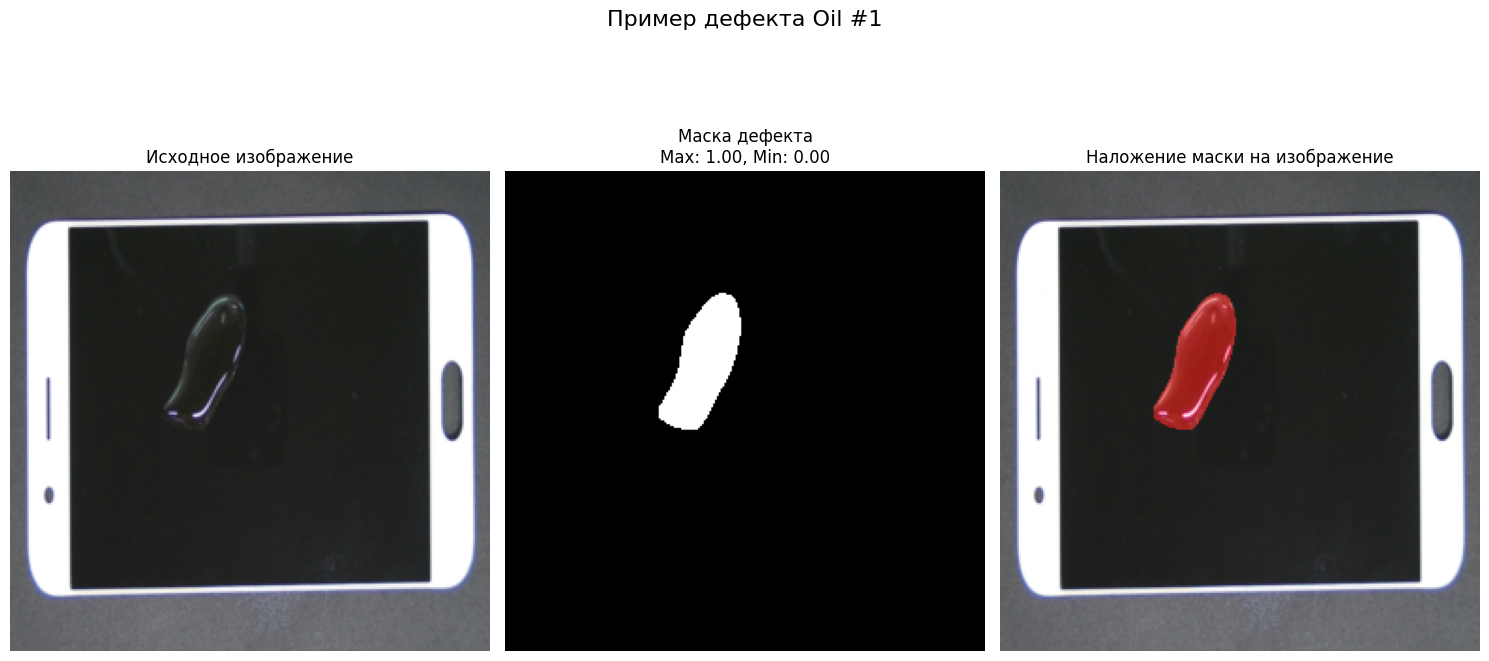

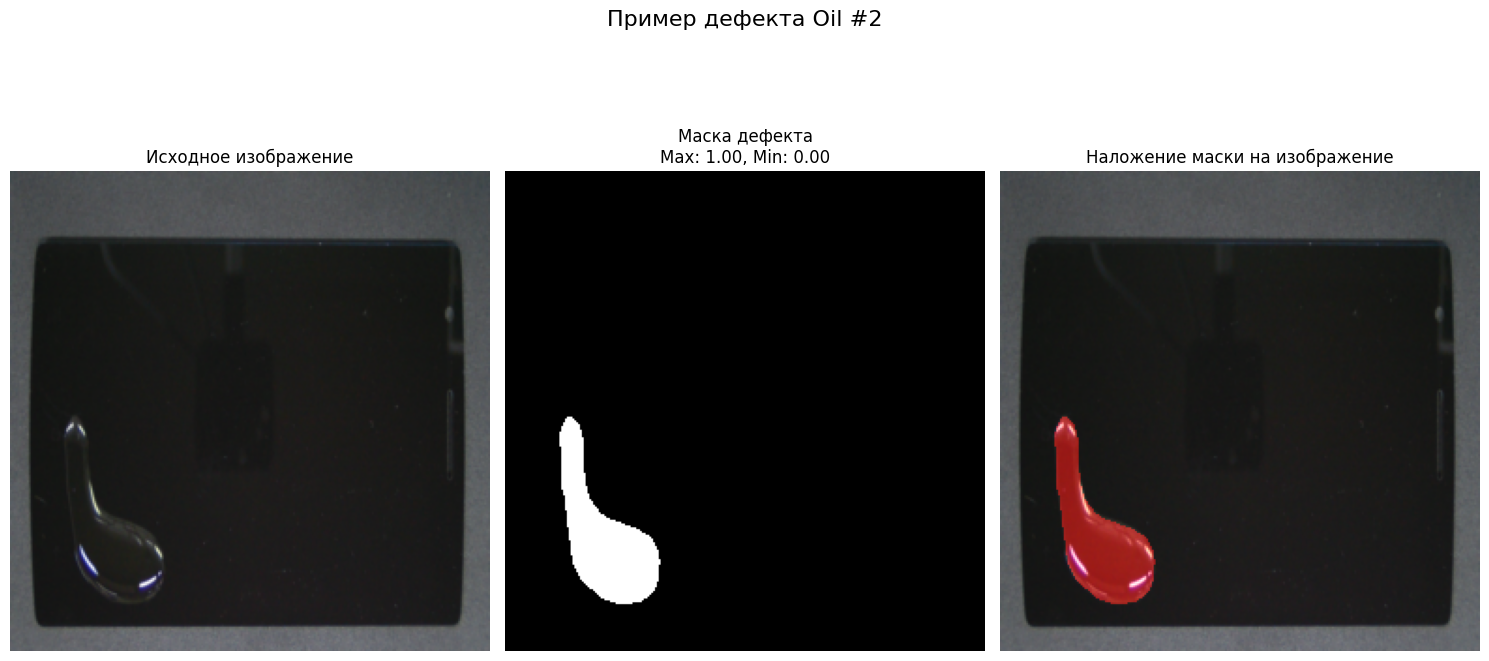

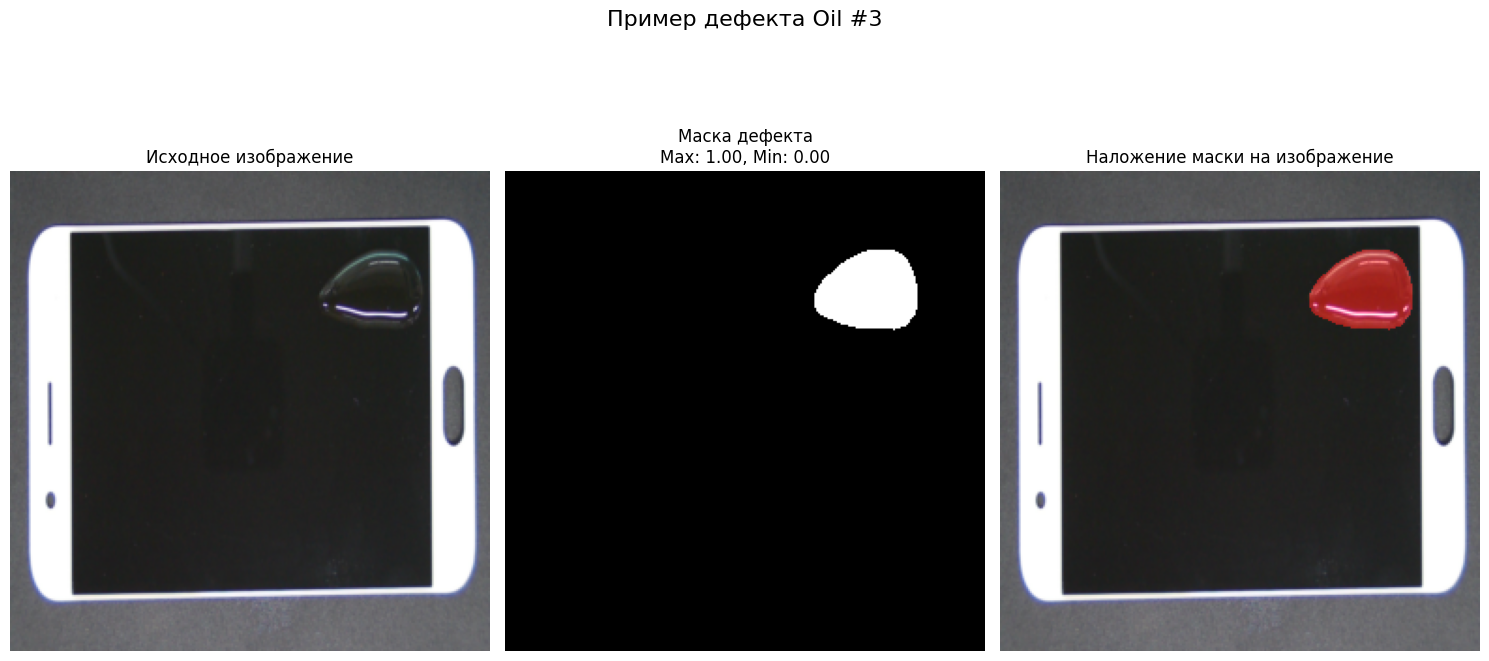

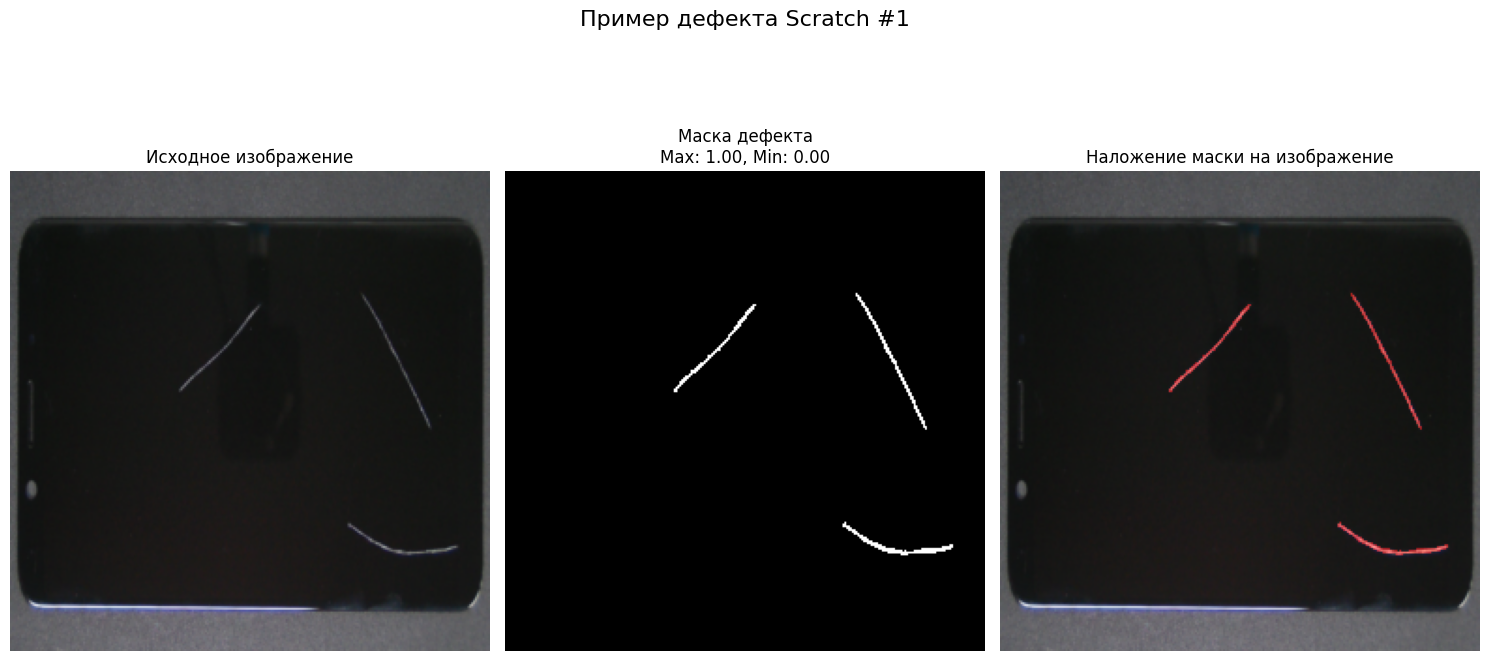

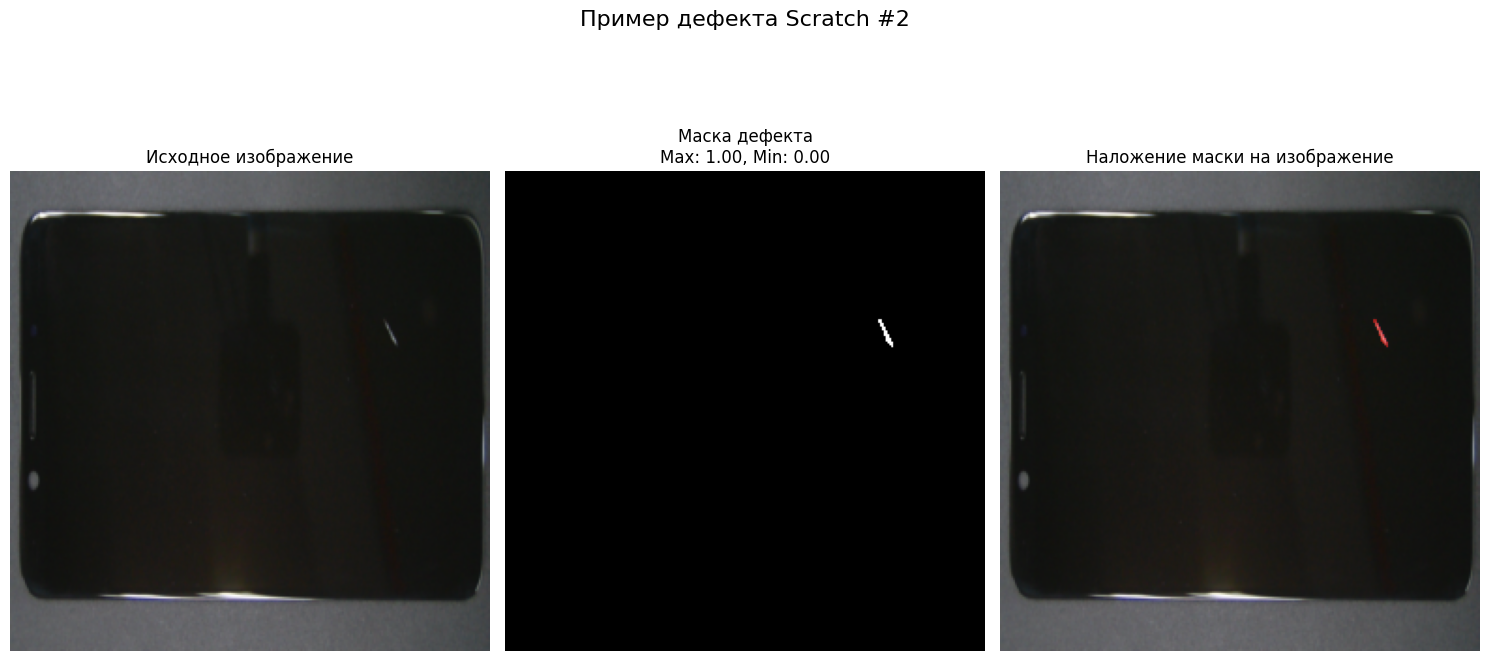

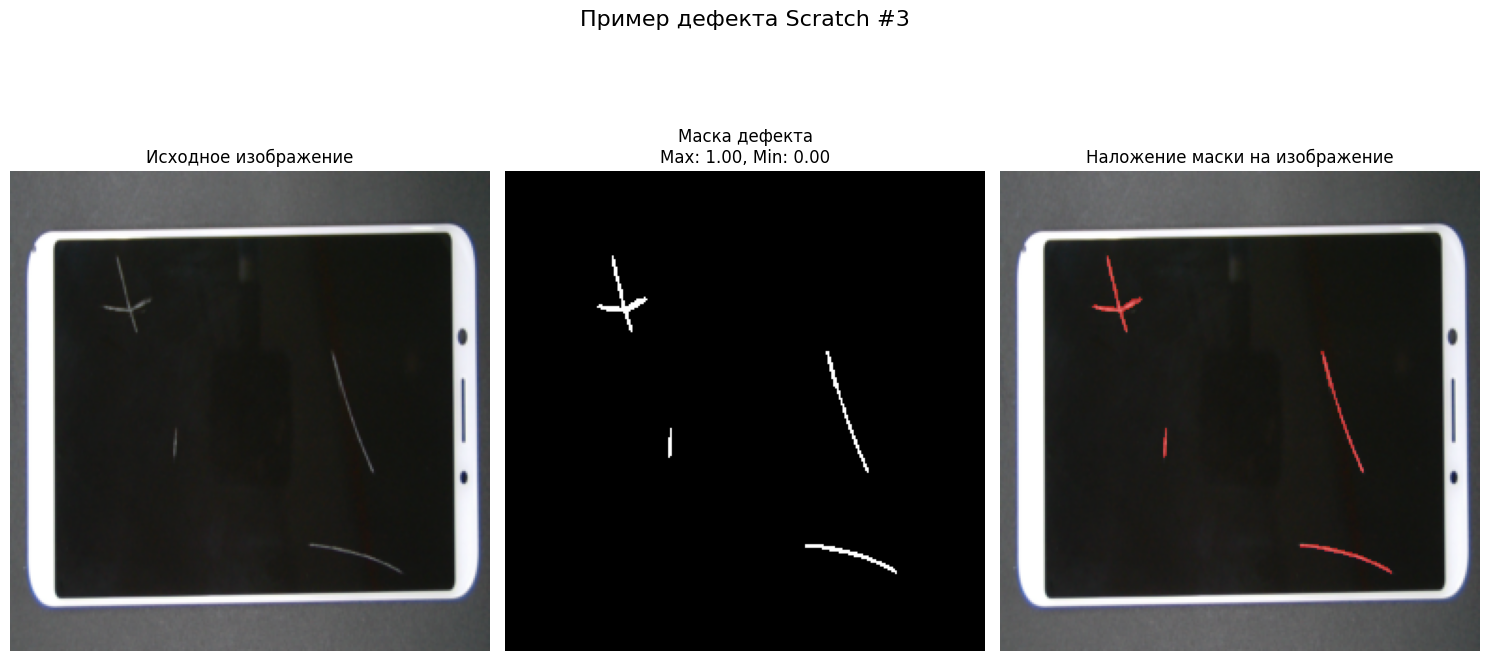

In [ ]:
for i in range(3):
    image, mask = dataset_oil[i]
    visualize_segmentation(image, mask, title=f"Пример дефекта Oil #{i+1}")

for i in range(3):
    image, mask = dataset_scratch[i]
    visualize_segmentation(image, mask, title=f"Пример дефекта Scratch #{i+1}")

Определим основные функции обучения и подсчета метрик

In [ ]:

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss


def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()

    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # IoU (Intersection over Union)
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Dice coefficient
    dice = (2 * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    # Pixel Accuracy
    total_pixels = true_mask.numel()
    correct_pixels = ((pred_mask == true_mask).sum()).float()
    pixel_accuracy = correct_pixels / total_pixels

    # Precision, Recall, F1
    true_positives = (pred_mask * true_mask).sum()
    false_positives = pred_mask.sum() - true_positives
    false_negatives = true_mask.sum() - true_positives

    precision = (true_positives + 1e-7) / (true_positives + false_positives + 1e-7)
    recall = (true_positives + 1e-7) / (true_positives + false_negatives + 1e-7)
    f1 = (2 * precision * recall + 1e-7) / (precision + recall + 1e-7)

    return {
        'iou': iou.item(),
        'dice': dice.item(),
        'pixel_accuracy': pixel_accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item()
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')
    best_iou = 0.0
    best_metrics = None
    best_model_wts = None
    history = {'train_loss': [], 'val_loss': [], 'val_metrics': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f'Эпоха {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        all_metrics = []

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc='Валидация'):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                for i in range(outputs.size(0)):
                    metrics = calculate_metrics(outputs[i], masks[i])
                    all_metrics.append(metrics)

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        avg_metrics = {}
        for metric in all_metrics[0].keys():
            avg_metrics[metric] = sum(item[metric] for item in all_metrics) / len(all_metrics)

        history['val_metrics'].append(avg_metrics)

        print(f'Потери: {train_loss:.4f}')
        print(f'Валидация - Потери: {val_loss:.4f}, IoU: {avg_metrics["iou"]:.4f}, Dice: {avg_metrics["dice"]:.4f}')

        if avg_metrics["iou"] > best_iou:
            best_iou = avg_metrics["iou"]
            best_model_wts = copy.deepcopy(model.state_dict())
            best_metrics = avg_metrics.copy()
            print(f'Новый лучший IoU: {best_iou:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_metrics

def visualize_training_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Потери на обучении')
    plt.plot(epochs, history['val_loss'], 'r-', label='Потери на валидации')
    plt.title('Динамика функции потерь')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [metrics['iou'] for metrics in history['val_metrics']], 'g-', label='IoU')
    plt.plot(epochs, [metrics['dice'] for metrics in history['val_metrics']], 'p-', label='Dice')
    plt.title('Метрики сегментации')
    plt.xlabel('Эпохи')
    plt.ylabel('Значение')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, num_samples=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples:
                break

            images = images.to(device)
            masks = masks.cpu()

            outputs = model(images)
            outputs = outputs.squeeze(1)
            pred_masks = (outputs > 0.5).float().cpu()

            for j in range(1):
                plt.figure(figsize=(10, 8))

                # Оригинальное изображение
                plt.subplot(1, 3, 1)
                plt.imshow(images[j].cpu().permute(1, 2, 0))
                plt.title('Изображение')
                plt.axis('off')

                # Истинная маска
                plt.subplot(1, 3, 2)
                plt.imshow(masks[j].squeeze(), cmap='gray')
                plt.title('Истинная маска')
                plt.axis('off')

                # Предсказанная маска
                plt.subplot(1, 3, 3)
                plt.imshow(pred_masks[j].squeeze(), cmap='gray')
                plt.title('Предсказанная маска')
                plt.axis('off')

                metrics = calculate_metrics(outputs[j].cpu(), masks[j])
                plt.suptitle(f'IoU: {metrics["iou"]:.4f}, Dice: {metrics["dice"]:.4f}')

                plt.tight_layout()
                plt.show()


def train_segmentation_pipeline(
        model, train_loader=train_loader, test_loader=test_loader, lr=0.0004, num_epochs=10,
        save_model=True, visualize_samples=5
    ):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCELoss()
    dice_loss = DiceLoss('binary')
    jaccard_loss = JaccardLoss('binary')

    def combined_loss(pred, target):
        target = target.float()
        return criterion(pred, target) + 0.5 * dice_loss(pred, target) + 0.5 * jaccard_loss(pred, target)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Начало обучения ...")
    model, history, metrics = train_model(
        model, train_loader, test_loader, combined_loss, optimizer, num_epochs=num_epochs
    )

    if save_model:
        print(f"Сохранение модели и метрик {model.name}...")
        torch.save(model.state_dict(), f'{model.name.lower()}_model.pth')

        with open(f'{model.name.lower()}_history.pkl', 'wb') as f:
            pickle.dump(history, f)

        with open(f'{model.name.lower()}_metrics.pkl', 'wb') as f:
            pickle.dump(metrics, f)

    print(f"Визуализация результатов {model.name}...")

    visualize_training_metrics(history)
    visualize_predictions(model, test_loader, num_samples=visualize_samples)

    final_metrics = history['val_metrics'][-1]
    print(f"Финальные метрики:")
    print(f"IoU: {final_metrics['iou']:.4f} | Dice: {final_metrics['dice']:.4f}")
    print(f"Точность пикселей: {final_metrics['pixel_accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f} | Recall: {final_metrics['recall']:.4f} | F1: {final_metrics['f1']:.4f}")

    return model, history, metrics


def visualize_model_metrics(metrics_dict, n_metrics=None, figsize=(12, 8)):
    model_names = list(metrics_dict.keys())

    first_model = model_names[0]
    metric_names = list(metrics_dict[first_model].keys())

    if n_metrics is not None and n_metrics < len(metric_names):
        metric_names = metric_names[:n_metrics]

    fig, ax = plt.subplots(figsize=figsize)

    bar_width = 0.8 / len(model_names)
    index = np.arange(len(metric_names))

    for i, model_name in enumerate(model_names):
        values = [metrics_dict[model_name][metric] for metric in metric_names]
        position = index + i * bar_width
        ax.bar(position, values, bar_width, label=model_name)

    ax.set_xlabel('Метрики')
    ax.set_ylabel('Значения')
    ax.set_title('Сравнение метрик моделей')
    ax.set_xticks(index + bar_width * (len(model_names) - 1) / 2)
    ax.set_xticklabels(metric_names)
    ax.legend()

    for i, model_name in enumerate(model_names):
        values = [metrics_dict[model_name][metric] for metric in metric_names]
        position = index + i * bar_width
        for j, v in enumerate(values):
            ax.text(position[j], v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# 1. Baseline

## Архитектура на основе CNN

In [ ]:
FPN_model = smp.FPN(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    classes=1,
    activation='sigmoid'
)
FPN_model.name = "FPN_resnet18"

In [ ]:
print("Архитектура FPN:")
print(FPN_model)

total_params = sum(p.numel() for p in FPN_model.parameters())
trainable_params = sum(p.numel() for p in FPN_model.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")


Архитектура FPN:
FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.0785
Валидация - Потери: 1.0053, IoU: 0.2637, Dice: 0.3287
Новый лучший IoU: 0.2637


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 0.9989
Валидация - Потери: 0.9995, IoU: 0.3204, Dice: 0.3878
Новый лучший IoU: 0.3204


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 0.9936
Валидация - Потери: 0.9915, IoU: 0.4551, Dice: 0.5392
Новый лучший IoU: 0.4551


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 0.9895
Валидация - Потери: 0.9902, IoU: 0.5446, Dice: 0.6601
Новый лучший IoU: 0.5446


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 0.9881
Валидация - Потери: 0.9900, IoU: 0.5492, Dice: 0.6604
Новый лучший IoU: 0.5492


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 0.9873
Валидация - Потери: 0.9883, IoU: 0.5767, Dice: 0.6860
Новый лучший IoU: 0.5767


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 0.9870
Валидация - Потери: 0.9892, IoU: 0.5172, Dice: 0.6058


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 0.9858
Валидация - Потери: 0.9873, IoU: 0.6030, Dice: 0.7104
Новый лучший IoU: 0.6030


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Потери: 0.9848
Валидация - Потери: 0.9854, IoU: 0.6002, Dice: 0.7113


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Потери: 0.9843
Валидация - Потери: 0.9869, IoU: 0.5495, Dice: 0.6432
Сохранение модели и метрик FPN_resnet18...
Визуализация результатов FPN_resnet18...


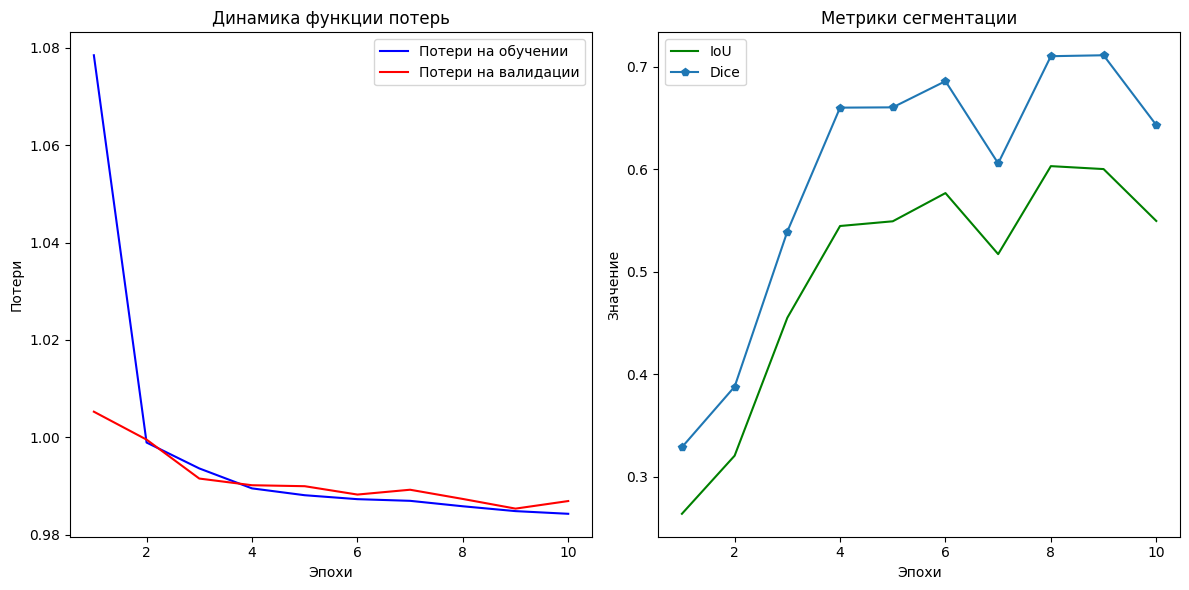

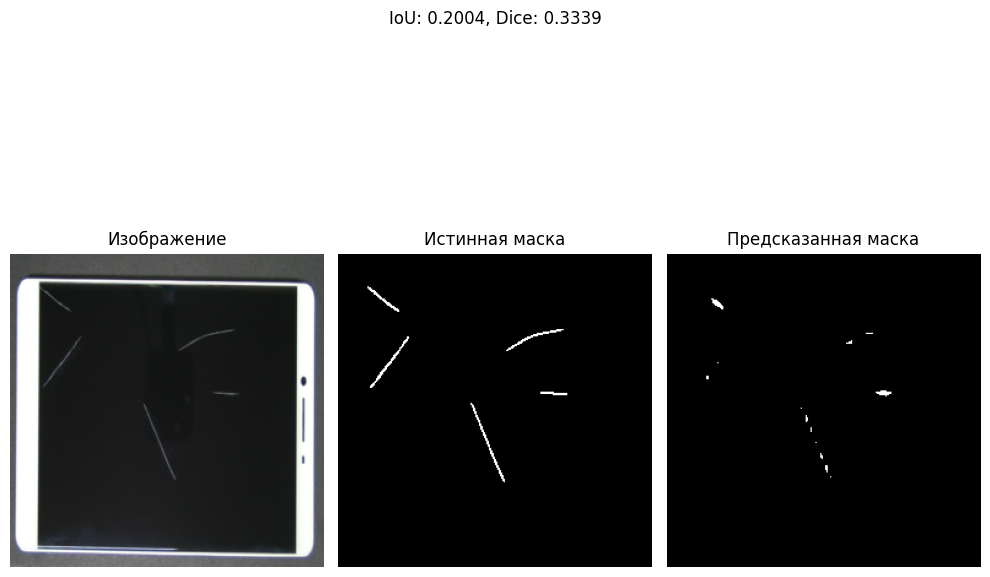

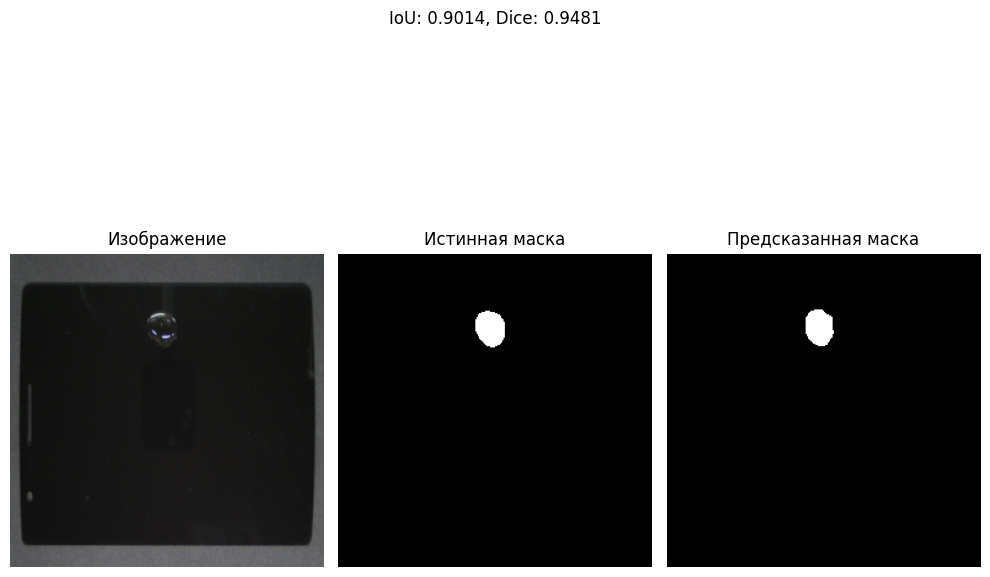

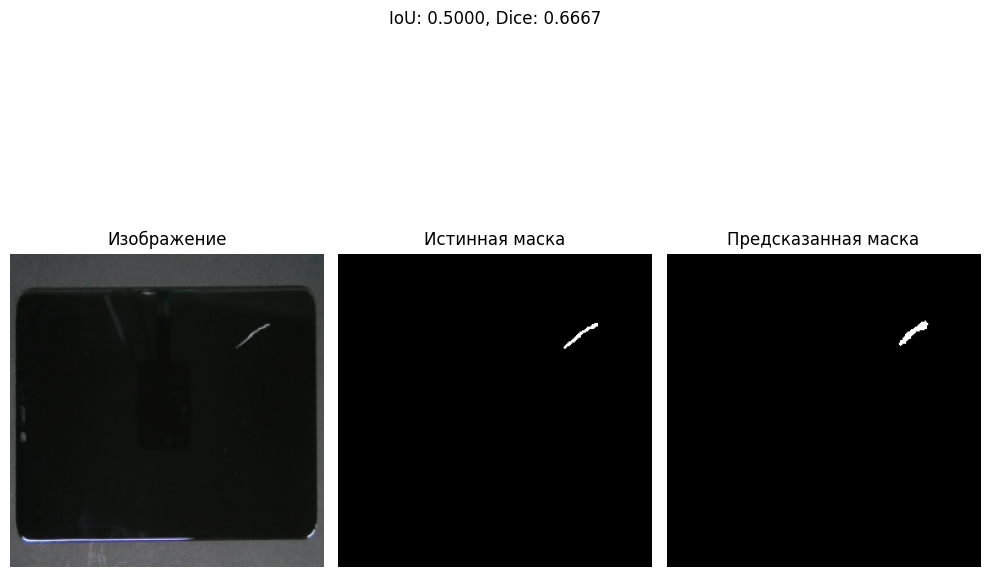

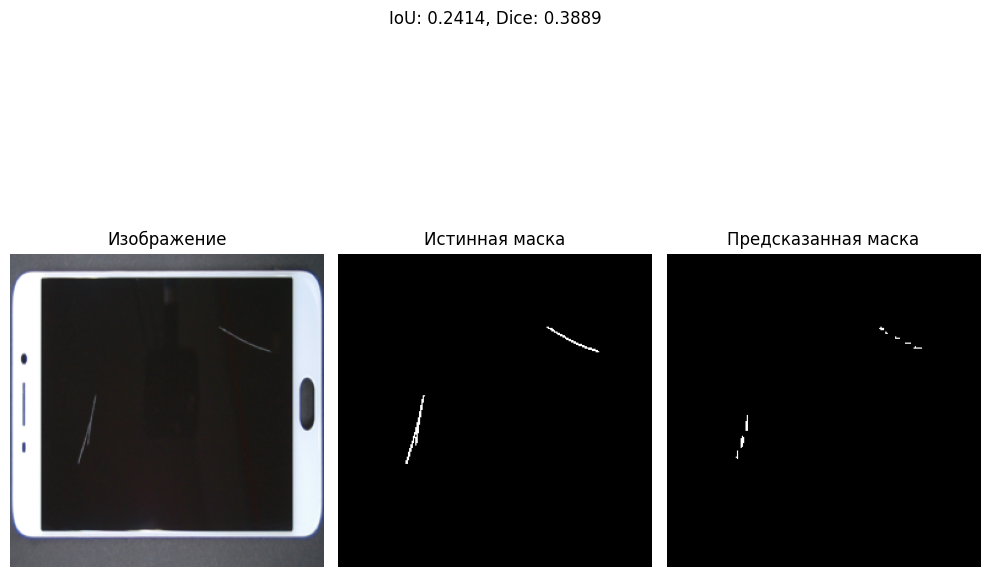

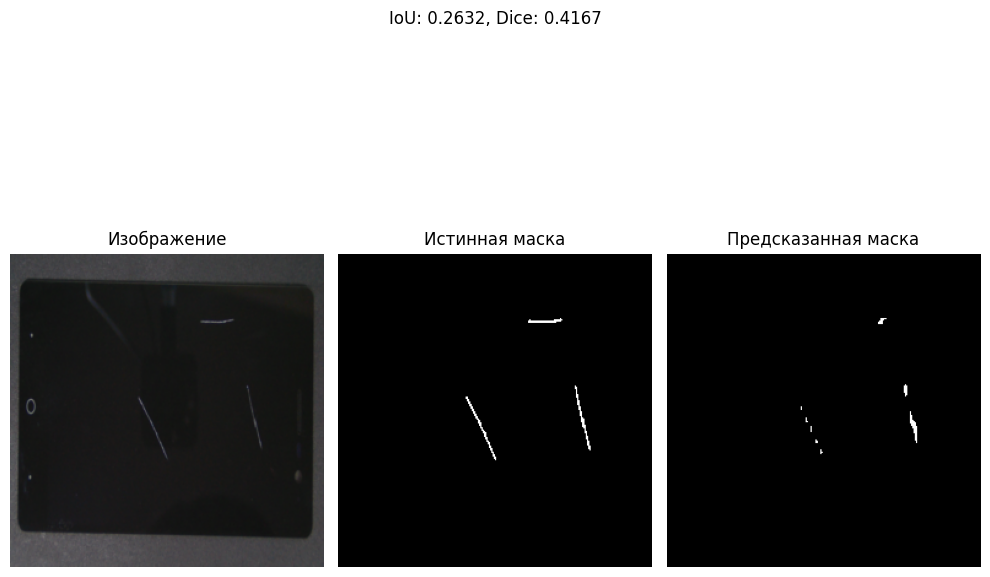

Финальные метрики:
IoU: 0.5495 | Dice: 0.6432
Точность пикселей: 0.9957
Precision: 0.8470 | Recall: 0.5908 | F1: 0.6432


In [ ]:
classes = ['фон', 'дефект']
FPN_model, fpn_history, fpn_metrics = train_segmentation_pipeline(FPN_model, num_epochs=10)

## Unet

In [ ]:
Unet_model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    classes=1,
    encoder_depth=3,
    decoder_channels=(64, 32, 16),
    decoder_use_batchnorm=False,
    activation='sigmoid'
)
Unet_model.name = "UNet-MobileNetV2-Light"


print("Архитектура улучшенного Unet:")
print(Unet_model)

total_params = sum(p.numel() for p in Unet_model.parameters())
trainable_params = sum(p.numel() for p in Unet_model.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Архитектура улучшенного Unet:
Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0):

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.1734
Валидация - Потери: 1.0305, IoU: 0.0000, Dice: 0.0000
Новый лучший IoU: 0.0000


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 1.0189
Валидация - Потери: 1.0139, IoU: 0.0475, Dice: 0.0834
Новый лучший IoU: 0.0475


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 1.0064
Валидация - Потери: 1.0037, IoU: 0.4184, Dice: 0.5751
Новый лучший IoU: 0.4184


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 0.9975
Валидация - Потери: 0.9951, IoU: 0.6151, Dice: 0.7398
Новый лучший IoU: 0.6151


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 0.9912
Валидация - Потери: 0.9907, IoU: 0.6629, Dice: 0.7769
Новый лучший IoU: 0.6629


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 0.9879
Валидация - Потери: 0.9890, IoU: 0.7110, Dice: 0.8170
Новый лучший IoU: 0.7110


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 0.9855
Валидация - Потери: 0.9884, IoU: 0.7430, Dice: 0.8416
Новый лучший IoU: 0.7430


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 0.9838
Валидация - Потери: 0.9868, IoU: 0.7742, Dice: 0.8655
Новый лучший IoU: 0.7742


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Потери: 0.9828
Валидация - Потери: 0.9889, IoU: 0.7720, Dice: 0.8620


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 0.9821
Валидация - Потери: 0.9857, IoU: 0.8013, Dice: 0.8842
Новый лучший IoU: 0.8013
Сохранение модели и метрик UNet-MobileNetV2-Light...
Визуализация результатов UNet-MobileNetV2-Light...


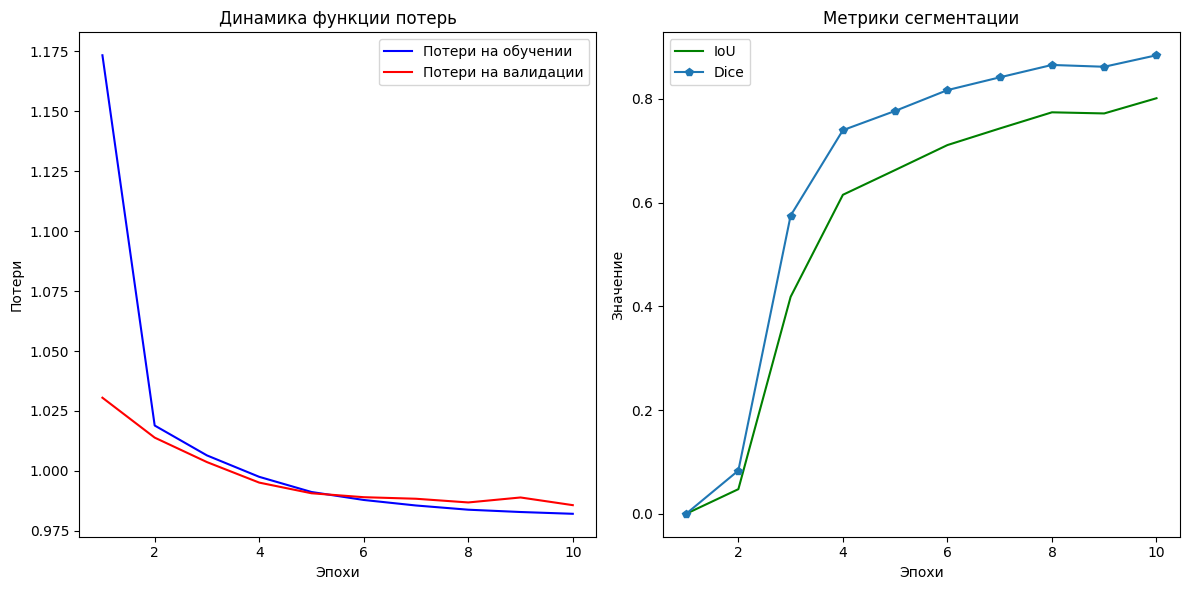

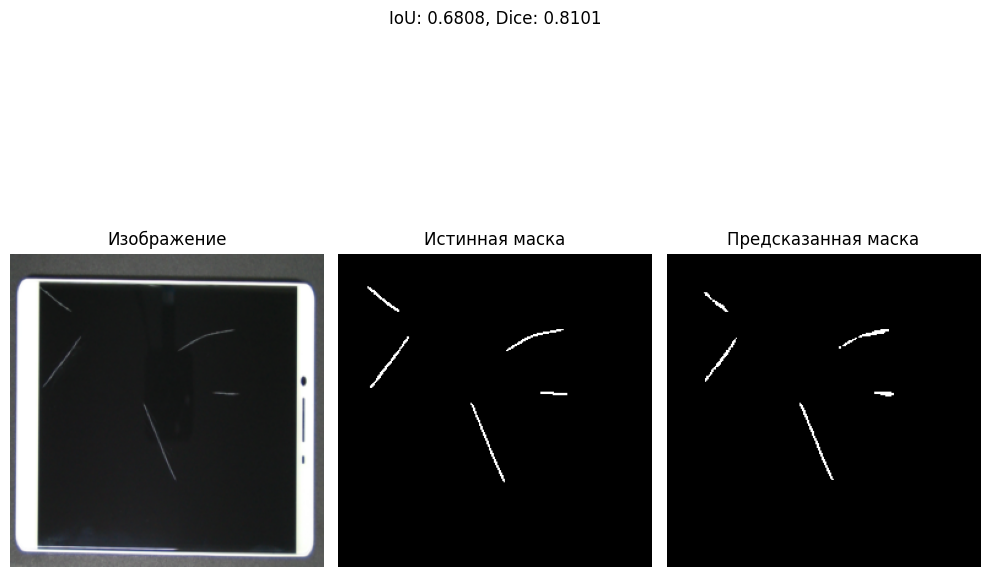

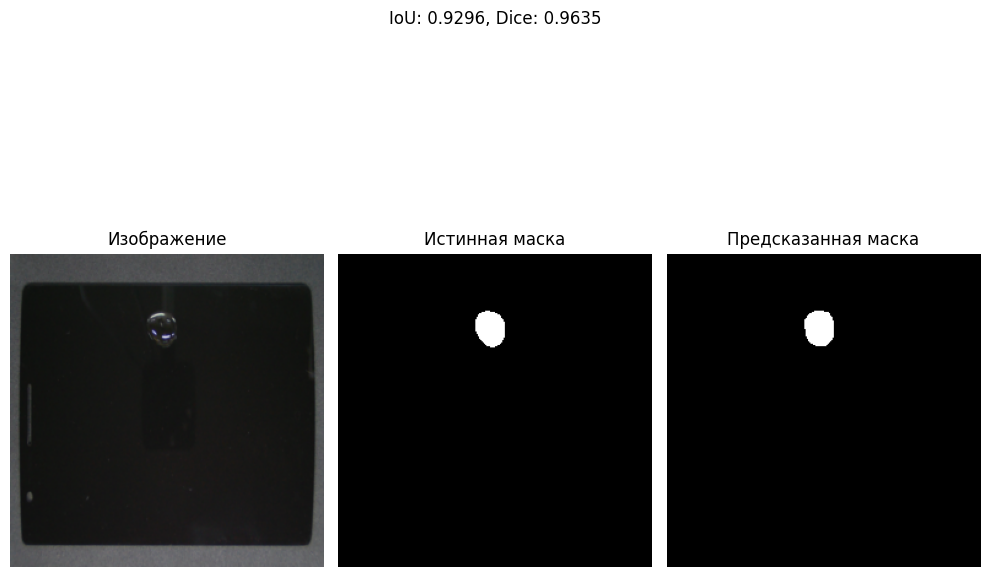

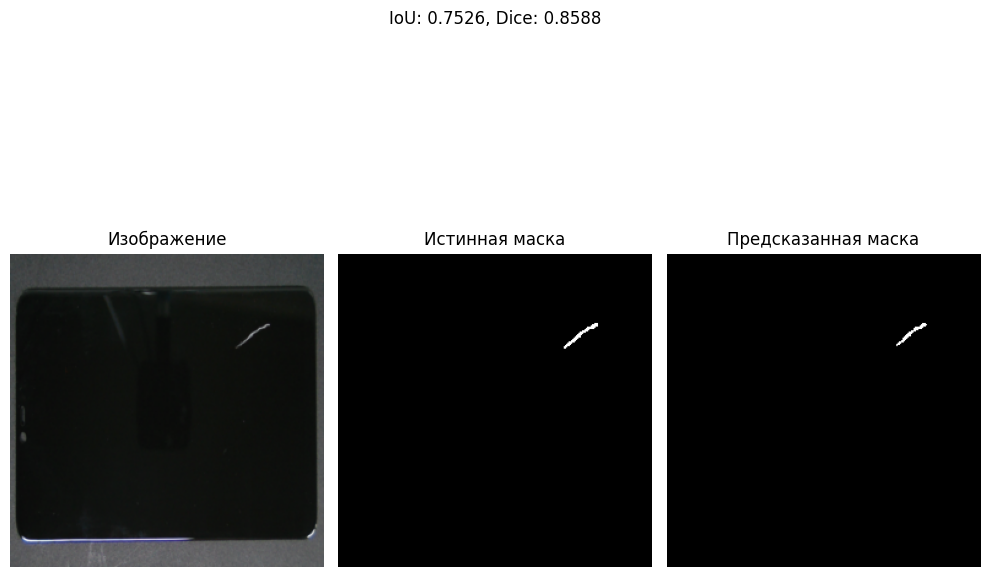

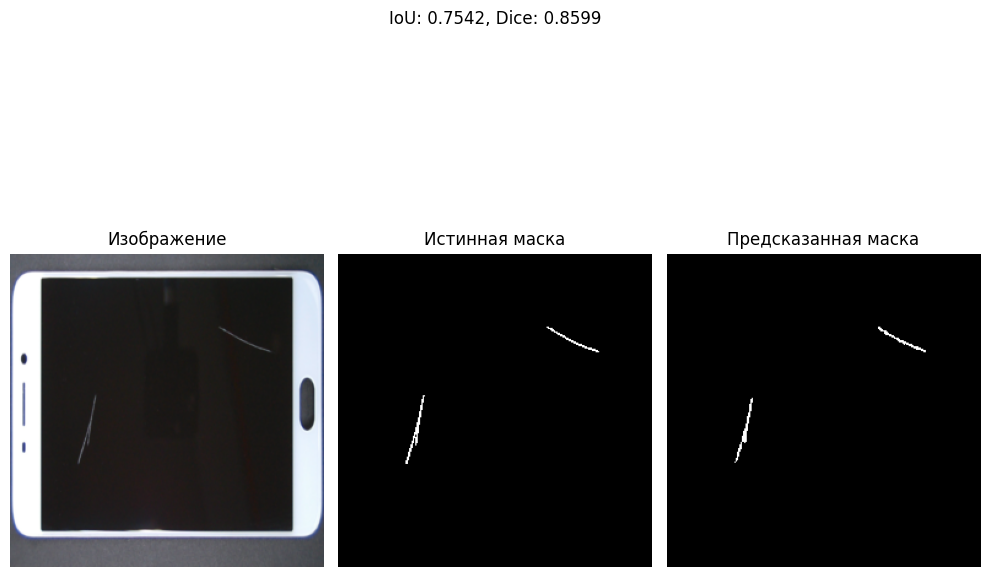

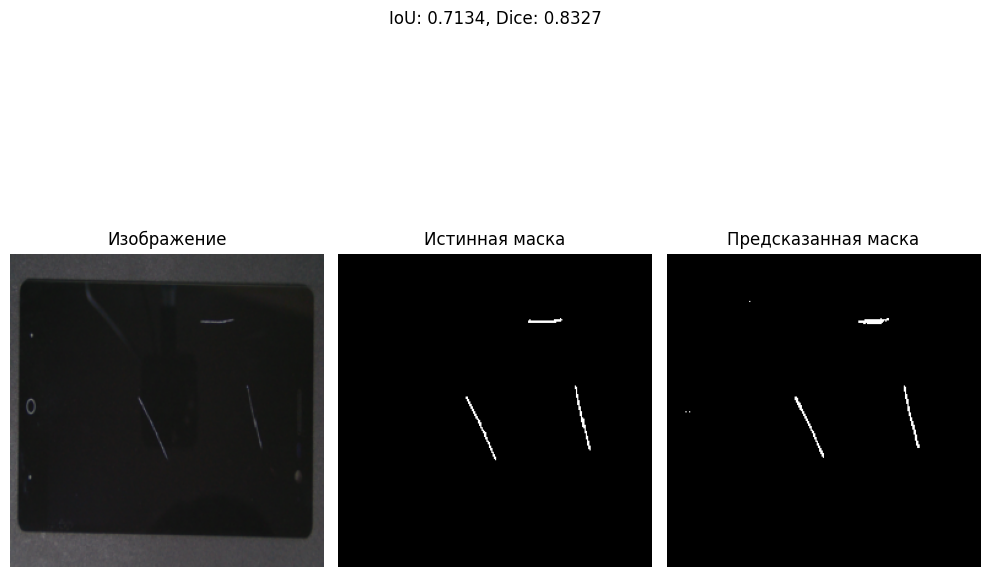

Финальные метрики:
IoU: 0.8013 | Dice: 0.8842
Точность пикселей: 0.9971
Precision: 0.8908 | Recall: 0.8880 | F1: 0.8842


In [ ]:
classes = ['фон', 'дефект']
ViT_model, vit_history, vit_metrics = train_segmentation_pipeline(Unet_model, num_epochs=10)

# Улучшенный baseline

- Гипотеза о влиянии архитектуры энкодера:
Базовая модель: FPN с ResNet50
Улучшенная модель: FPN с EfficientNet-B4
Проверяем гипотезу, что более современная и мощная архитектура энкодера (EfficientNet-B4) даст лучшие результаты

- Проверяем, что расширенная аугментация (повороты, отражения, изменение яркости и контраста) улучшит обобщающую способность модели

- Проверяем, что более длительное обучение с большим батчем даст лучшие результаты

In [ ]:
# расширенная аугментация
transform_improved = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

mask_transform_improved = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

data_dir = Path("")

dataset_oil_improved = MobilePhoneDefectDataset(
    data_dir=data_dir,
    image_folder="oil",
    mask_folder="ground_truth_2",
    transform=transform_improved,
    mask_transform=mask_transform_improved
)

dataset_scratch_improved = MobilePhoneDefectDataset(
    data_dir=data_dir,
    image_folder="scratch",
    mask_folder="ground_truth_1",
    transform=transform_improved,
    mask_transform=mask_transform_improved
)

dataset_improved_combined = torch.utils.data.ConcatDataset([dataset_oil_improved, dataset_scratch_improved])

train_size = int(0.8 * len(dataset_combined))
test_size = len(dataset_combined) - train_size
train_dataset_improved, test_dataset_improved = torch.utils.data.random_split(dataset_combined, [train_size, test_size])

batch_size = 32
train_loader_improved = DataLoader(train_dataset_improved, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=batch_size, shuffle=False, num_workers=2)

## Создаем улучшенную версию FPN с более мощным энкодером

In [ ]:
FPN_improved = smp.FPN(
    encoder_name="efficientnet-b5",  # Используем более мощный энкодер
    encoder_weights="imagenet",
    classes=1,
    activation='sigmoid'
)
FPN_improved.name = "FPN-efficientnet-b5"

print("Архитектура улучшенного FPN:")
print(FPN_improved)

total_params = sum(p.numel() for p in FPN_improved.parameters())
trainable_params = sum(p.numel() for p in FPN_improved.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Архитектура улучшенного FPN:
FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
     

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Потери: 1.1534
Валидация - Потери: 1.0093, IoU: 0.2014, Dice: 0.2650
Новый лучший IoU: 0.2014


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Потери: 0.9939
Валидация - Потери: 1.0090, IoU: 0.1559, Dice: 0.2188


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9885
Валидация - Потери: 1.0050, IoU: 0.2081, Dice: 0.2725
Новый лучший IoU: 0.2081


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Потери: 0.9870
Валидация - Потери: 0.9968, IoU: 0.3294, Dice: 0.4086
Новый лучший IoU: 0.3294


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Потери: 0.9849
Валидация - Потери: 0.9974, IoU: 0.3228, Dice: 0.3944


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9839
Валидация - Потери: 0.9911, IoU: 0.4746, Dice: 0.5647
Новый лучший IoU: 0.4746


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9836
Валидация - Потери: 0.9912, IoU: 0.4410, Dice: 0.5219


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Потери: 0.9828
Валидация - Потери: 0.9896, IoU: 0.4706, Dice: 0.5599


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Потери: 0.9824
Валидация - Потери: 0.9870, IoU: 0.5448, Dice: 0.6396
Новый лучший IoU: 0.5448


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Потери: 0.9820
Валидация - Потери: 0.9853, IoU: 0.6154, Dice: 0.7194
Новый лучший IoU: 0.6154


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9818
Валидация - Потери: 0.9852, IoU: 0.5927, Dice: 0.6967


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9816
Валидация - Потери: 0.9853, IoU: 0.5586, Dice: 0.6534


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 0.9816
Валидация - Потери: 0.9836, IoU: 0.6192, Dice: 0.7202
Новый лучший IoU: 0.6192


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Потери: 0.9813
Валидация - Потери: 0.9824, IoU: 0.7170, Dice: 0.8166
Новый лучший IoU: 0.7170


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Потери: 0.9812
Валидация - Потери: 0.9820, IoU: 0.7356, Dice: 0.8327
Новый лучший IoU: 0.7356
Сохранение модели и метрик FPN-efficientnet-b5...
Визуализация результатов FPN-efficientnet-b5...


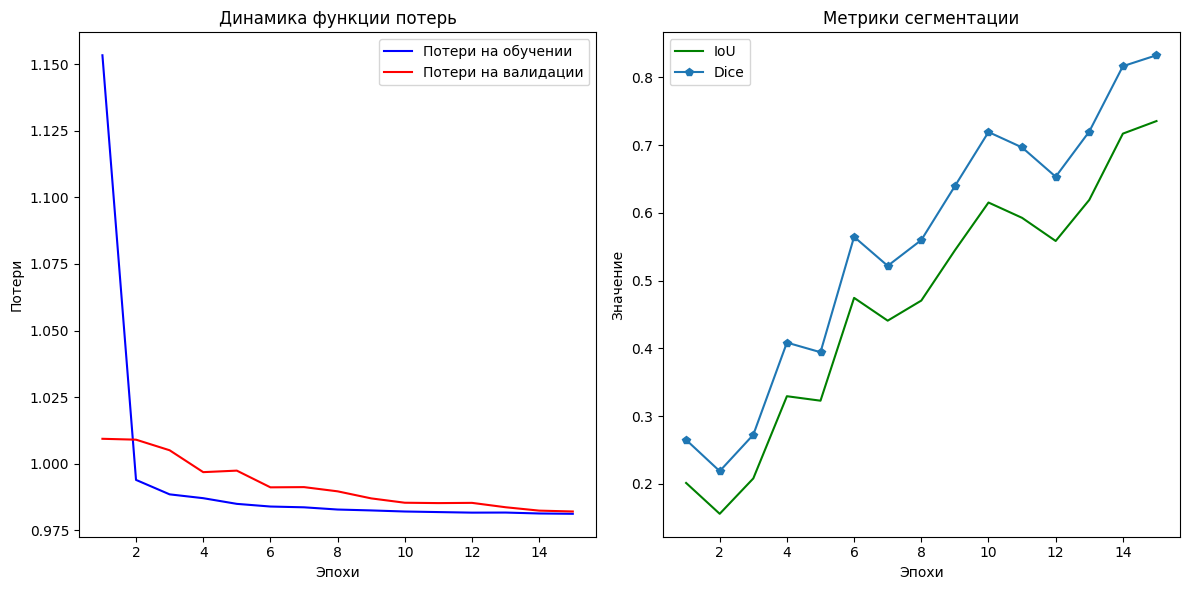

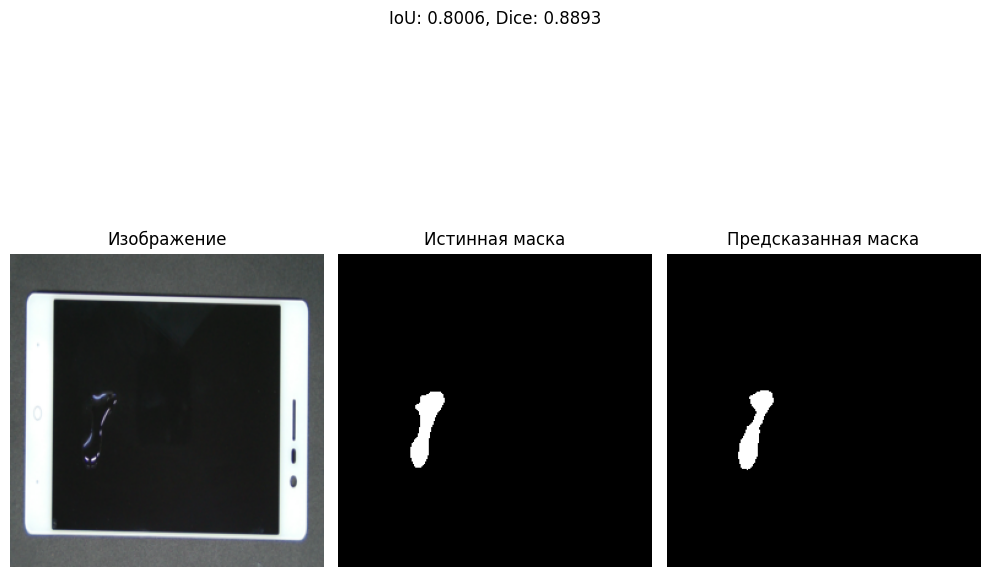

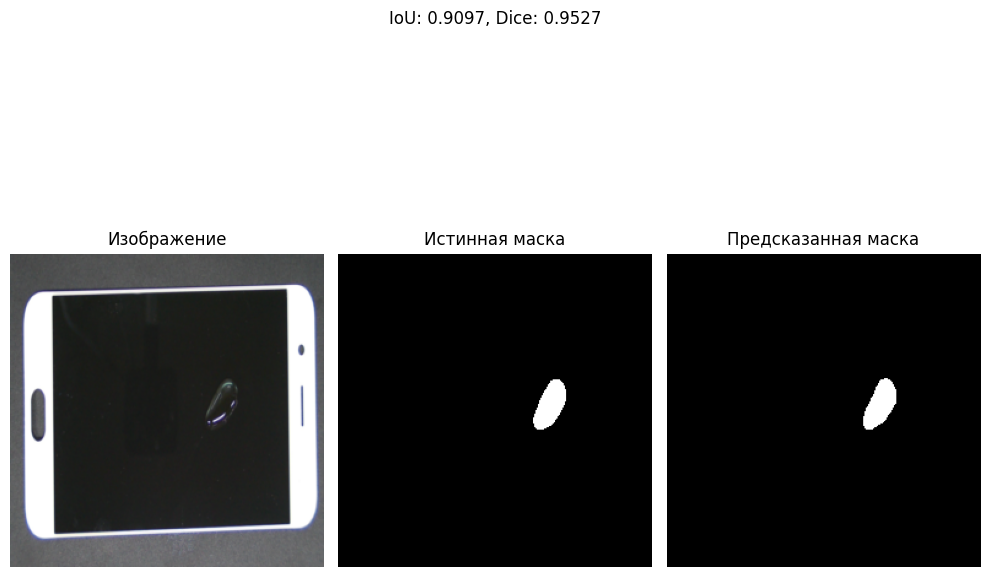

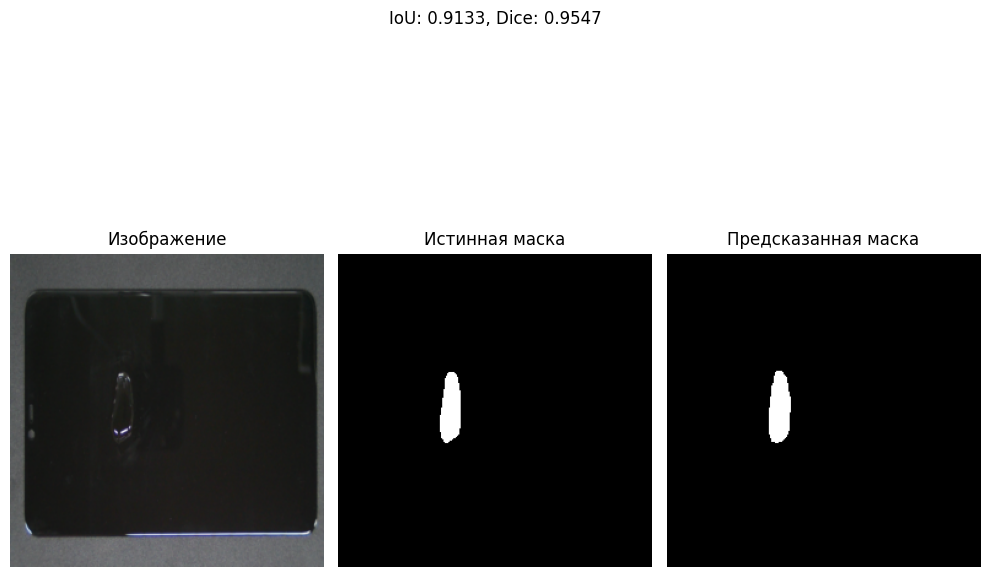

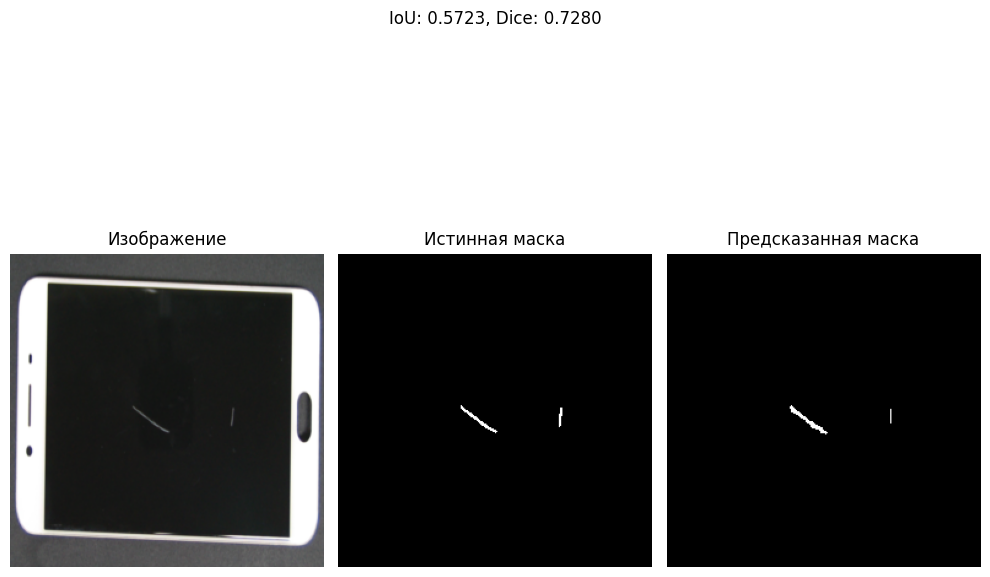

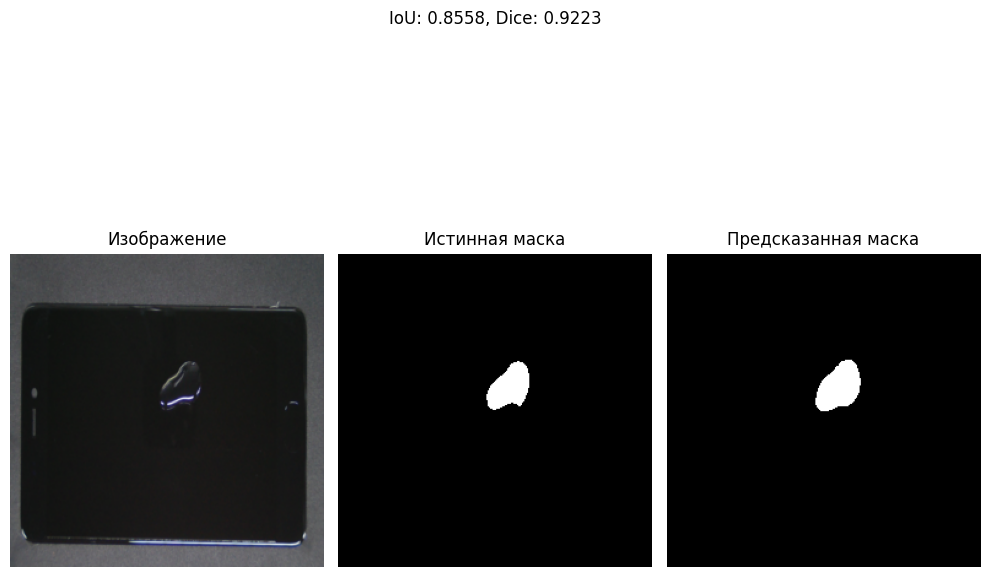

Финальные метрики:
IoU: 0.7356 | Dice: 0.8327
Точность пикселей: 0.9975
Precision: 0.8241 | Recall: 0.8487 | F1: 0.8327


In [ ]:
classes = ['фон', 'дефект']
FPN_improved, fpn_improved_history, fpn_improved_metrics = train_segmentation_pipeline(
    FPN_improved,
    train_loader=train_loader_improved,
    test_loader=test_loader_improved,
    lr=0.001,
    num_epochs=15,  # Увеличиваем количество эпох
    save_model=True,
    visualize_samples=5
)


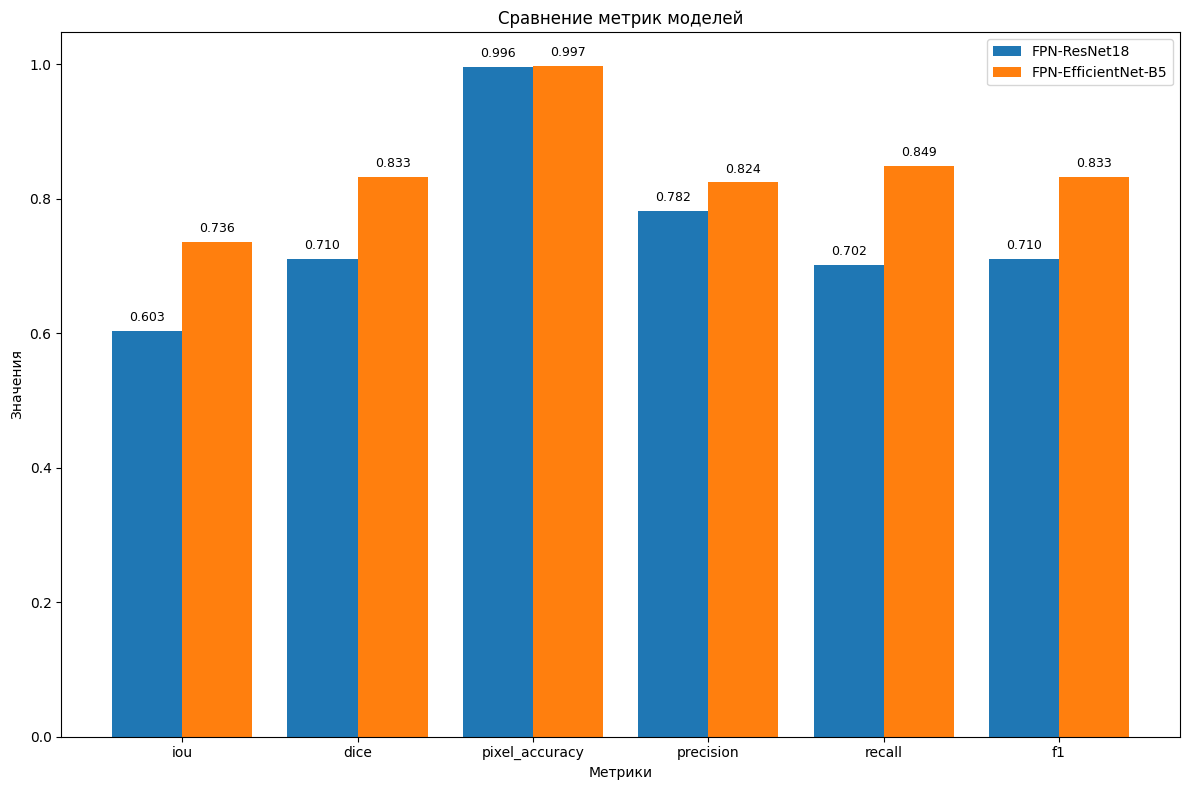

In [ ]:
FPN_resnet18_metrics = pickle.load(open("fpn_resnet18_metrics.pkl", "rb"))
FPN_efficientnet_b5_metrics = pickle.load(open("fpn-efficientnet-b5_metrics.pkl", "rb"))

models_metrics = {
    "FPN-ResNet18": FPN_resnet18_metrics,
    "FPN-EfficientNet-B5": FPN_efficientnet_b5_metrics
}

visualize_model_metrics(models_metrics)


## Улучшенный Unet с новых энкодером

In [ ]:
# Используем UNet с легким энкодером MobileNetV2 для экономии памяти
Unet_improved_model = smp.Unet(
    encoder_name="mobilenet_v2",  # Легкий и эффективный энкодер
    encoder_weights="imagenet",
    classes=1,
    encoder_depth=4,
    decoder_channels=(128, 64, 32, 16),  # Уменьшаем размерность каналов
    decoder_use_batchnorm=True,
    activation='sigmoid'
)
Unet_improved_model.name = "UNet-MobileNetV2"


print("Архитектура улучшенного Unet:")
print(Unet_improved_model)

total_params = sum(p.numel() for p in Unet_improved_model.parameters())
trainable_params = sum(p.numel() for p in Unet_improved_model.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

Архитектура улучшенного Unet:
Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0):

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.4865
Валидация - Потери: 1.3314, IoU: 0.1392, Dice: 0.2297
Новый лучший IoU: 0.1392


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 1.2423
Валидация - Потери: 1.1708, IoU: 0.4570, Dice: 0.5951
Новый лучший IoU: 0.4570


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.1527
Валидация - Потери: 1.1212, IoU: 0.5303, Dice: 0.6259
Новый лучший IoU: 0.5303


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.1040
Валидация - Потери: 1.0864, IoU: 0.5792, Dice: 0.6809
Новый лучший IoU: 0.5792


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Потери: 1.0702
Валидация - Потери: 1.0621, IoU: 0.6138, Dice: 0.7171
Новый лучший IoU: 0.6138


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Потери: 1.0512
Валидация - Потери: 1.0481, IoU: 0.6705, Dice: 0.7869
Новый лучший IoU: 0.6705


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 1.0399
Валидация - Потери: 1.0357, IoU: 0.7100, Dice: 0.8176
Новый лучший IoU: 0.7100


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0309
Валидация - Потери: 1.0294, IoU: 0.7187, Dice: 0.8134
Новый лучший IoU: 0.7187


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0242
Валидация - Потери: 1.0241, IoU: 0.7692, Dice: 0.8580
Новый лучший IoU: 0.7692


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.0188
Валидация - Потери: 1.0166, IoU: 0.7831, Dice: 0.8707
Новый лучший IoU: 0.7831


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0149
Валидация - Потери: 1.0149, IoU: 0.7844, Dice: 0.8690
Новый лучший IoU: 0.7844


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.0109
Валидация - Потери: 1.0104, IoU: 0.8156, Dice: 0.8931
Новый лучший IoU: 0.8156


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Потери: 1.0070
Валидация - Потери: 1.0069, IoU: 0.8204, Dice: 0.8961
Новый лучший IoU: 0.8204


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Потери: 1.0042
Валидация - Потери: 1.0040, IoU: 0.8300, Dice: 0.9029
Новый лучший IoU: 0.8300


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Потери: 1.0018
Валидация - Потери: 1.0019, IoU: 0.8183, Dice: 0.8958
Сохранение модели и метрик UNet-MobileNetV2...
Визуализация результатов UNet-MobileNetV2...


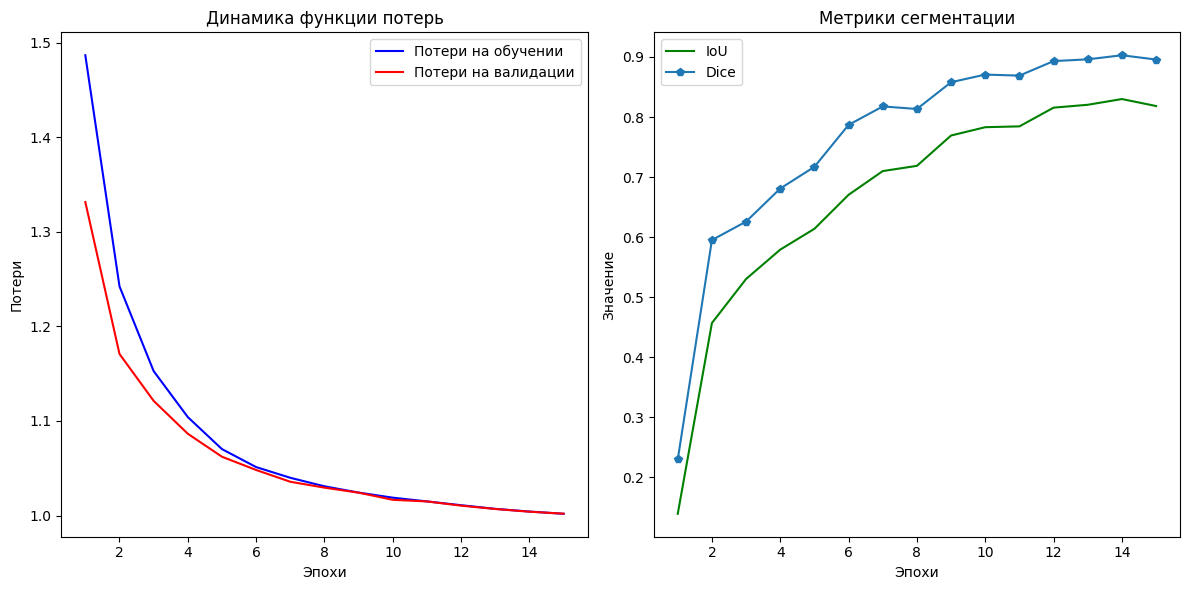

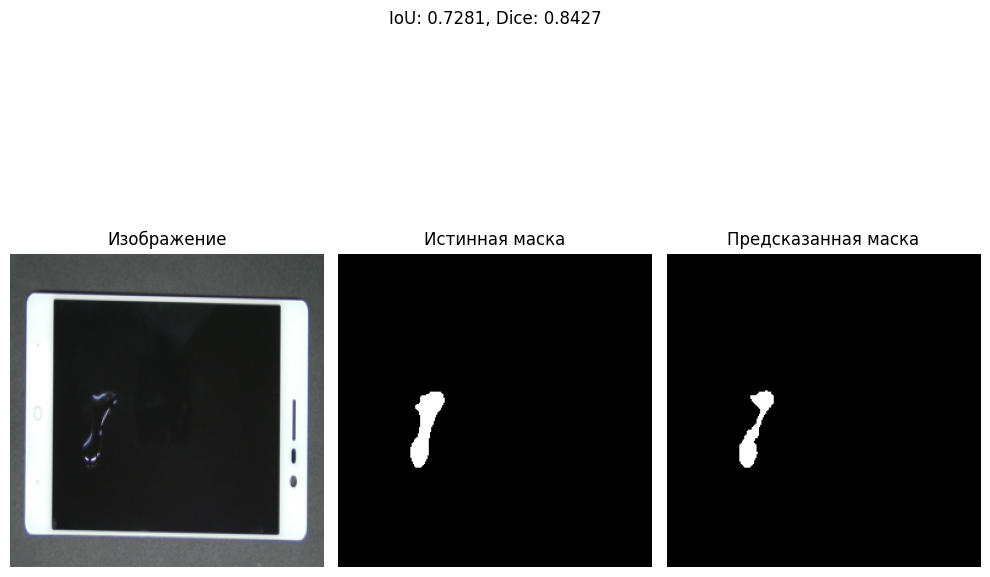

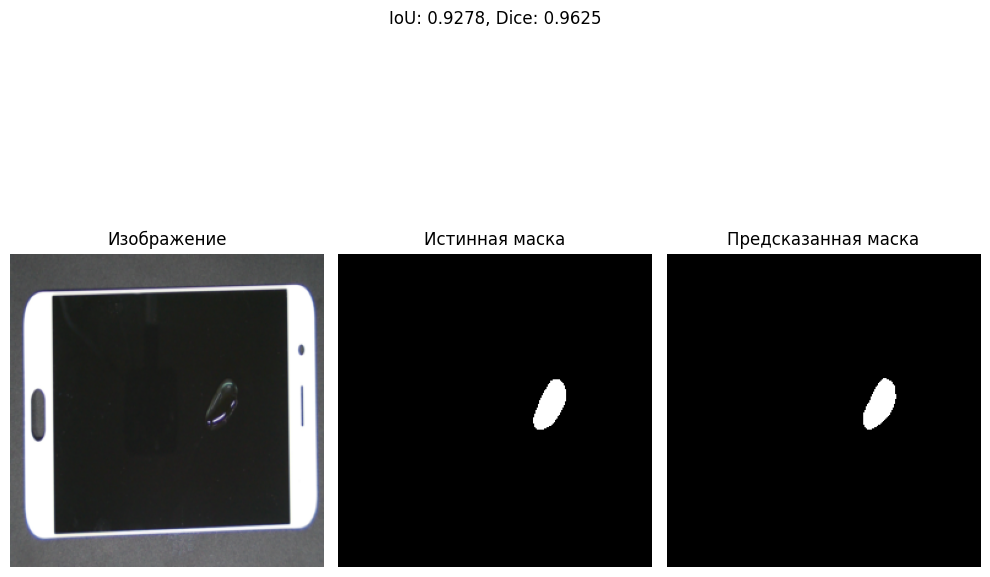

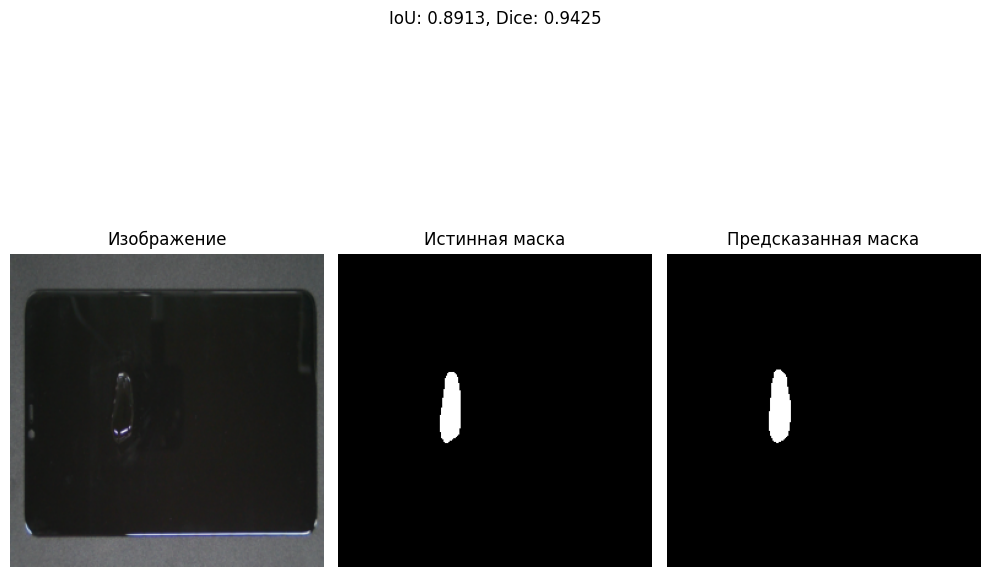

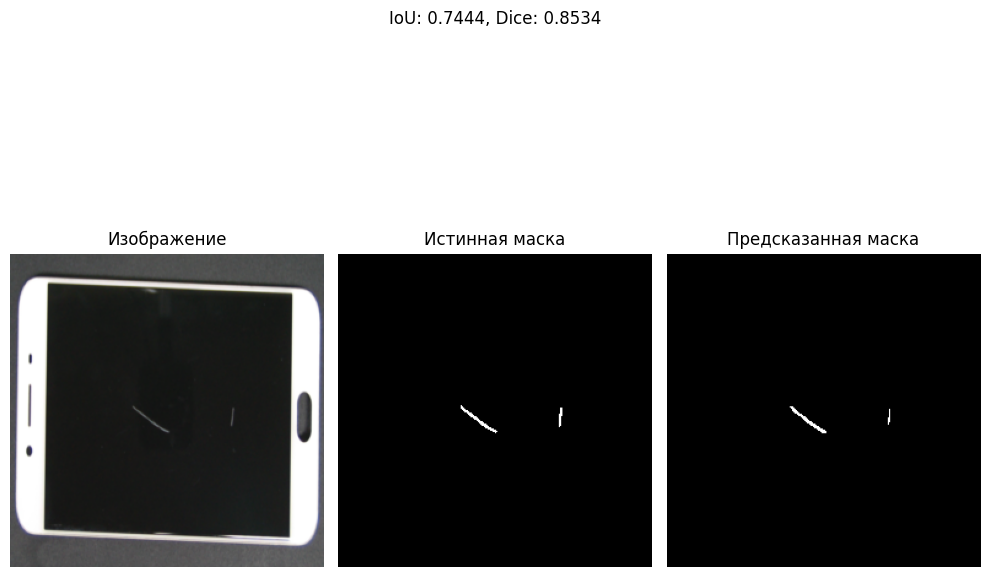

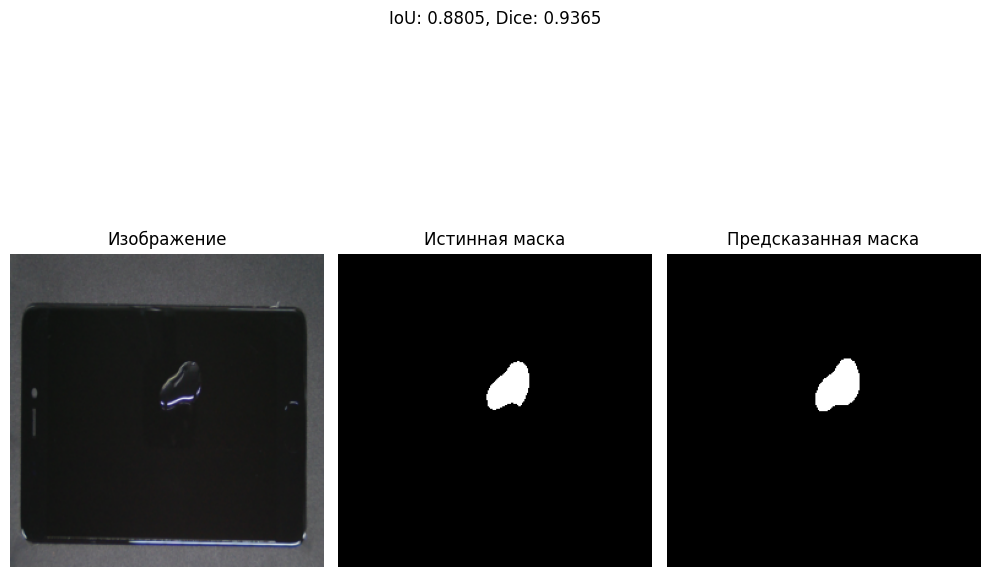

Финальные метрики:
IoU: 0.8183 | Dice: 0.8958
Точность пикселей: 0.9984
Precision: 0.8622 | Recall: 0.9388 | F1: 0.8958


In [ ]:
classes = ['фон', 'дефект']
Unet_improved_model, Unet_improved_model_history, Unet_improved_model_metrics = train_segmentation_pipeline(
    Unet_improved_model,
    train_loader=train_loader_improved,
    test_loader=test_loader_improved,
    lr=0.0003,
    num_epochs=15,  # Увеличиваем количество эпох
    save_model=True,
    visualize_samples=5
)


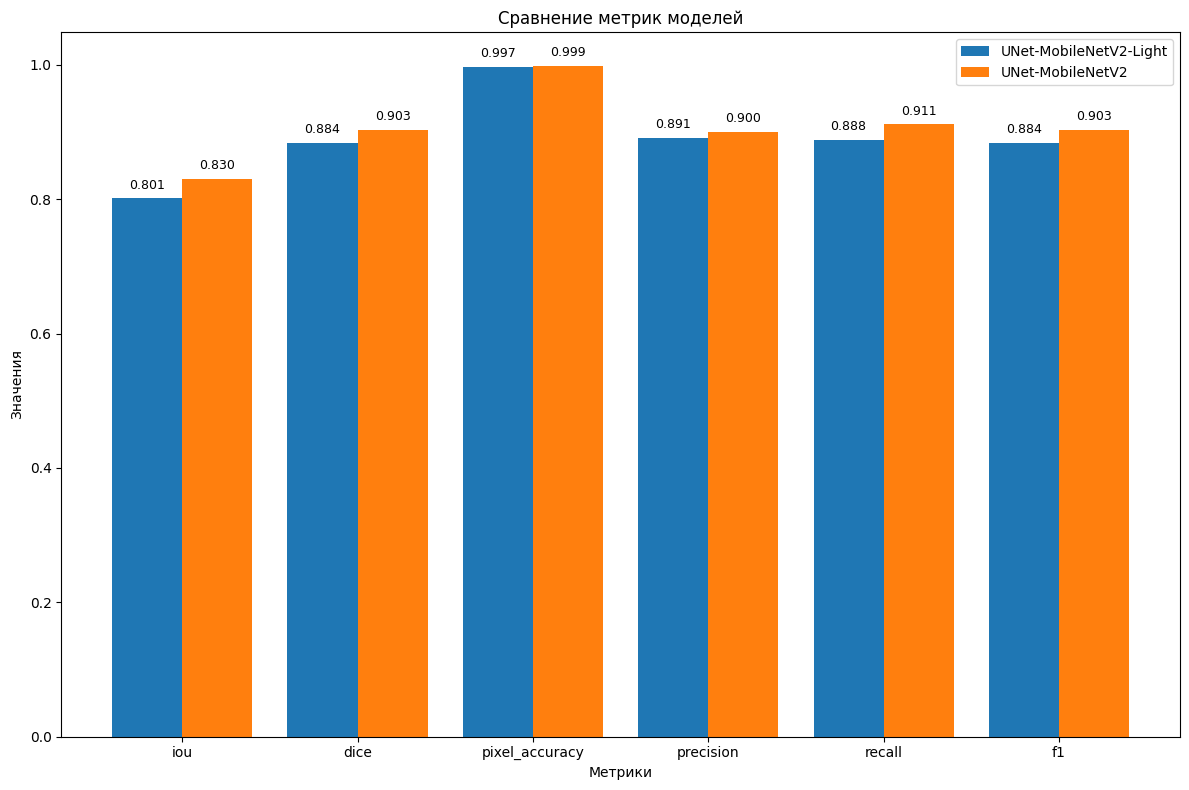

In [ ]:
unet_mobilenetv2_light_metrics = pickle.load(open("unet-mobilenetv2-light_metrics.pkl", "rb"))
unet_mobilenetv2_metrics = pickle.load(open("unet-mobilenetv2_metrics.pkl", "rb"))

models_metrics = {
    "UNet-MobileNetV2-Light": unet_mobilenetv2_light_metrics,
    "UNet-MobileNetV2": unet_mobilenetv2_metrics
}

visualize_model_metrics(models_metrics)


- Гипотеза о влиянии архитектуры энкодера подтвердилась, использование более сложных энкодеров позволилло повысить качество

- Расширенная аугментация (повороты, отражения, изменение яркости и контраста) улучшила обобщающую способность модели

- Более длительное обучение дало лучшие результаты

**При этом наилучшие результаты показала архитектура Unet**

# Собственная имплиминтация модели

## Без улучшений

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Двойная свертка: Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm -> ReLU"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Понижение разрешения с помощью maxpool и двойной свертки"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Повышение разрешения с помощью транспонированной свертки и конкатенация с пропущенными связями"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class CustomUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(CustomUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Энкодер - уменьшаем количество фильтров
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)

        # Декодер - соответственно уменьшаем
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)

        self.outc = OutConv(32, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Энкодер
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Декодер с skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)

        return self.sigmoid(logits)


In [ ]:
SimpleUnet = CustomUNet(n_channels=3, n_classes=1, bilinear=True)
SimpleUnet.name = "SimpleUnet"


print("Собственная реализация Unet:")
print(SimpleUnet)

total_params = sum(p.numel() for p in SimpleUnet.parameters())
trainable_params = sum(p.numel() for p in SimpleUnet.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

Собственная реализация Unet:
CustomUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Bat

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Потери: 1.6209
Валидация - Потери: 1.6209, IoU: 0.0006, Dice: 0.0012
Новый лучший IoU: 0.0006


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.4936
Валидация - Потери: 1.4923, IoU: 0.1687, Dice: 0.2433
Новый лучший IoU: 0.1687


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.4530
Валидация - Потери: 1.4310, IoU: 0.2486, Dice: 0.3183
Новый лучший IoU: 0.2486


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.4167
Валидация - Потери: 1.4018, IoU: 0.2780, Dice: 0.3652
Новый лучший IoU: 0.2780


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.3844
Валидация - Потери: 1.3654, IoU: 0.3393, Dice: 0.4480
Новый лучший IoU: 0.3393


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Потери: 1.3559
Валидация - Потери: 1.3511, IoU: 0.5426, Dice: 0.6672
Новый лучший IoU: 0.5426


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.3295
Валидация - Потери: 1.3262, IoU: 0.5840, Dice: 0.7033
Новый лучший IoU: 0.5840


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.3037
Валидация - Потери: 1.3016, IoU: 0.6420, Dice: 0.7473
Новый лучший IoU: 0.6420


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Потери: 1.2788
Валидация - Потери: 1.2792, IoU: 0.7136, Dice: 0.8217
Новый лучший IoU: 0.7136


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.2562
Валидация - Потери: 1.2512, IoU: 0.6833, Dice: 0.8046
Сохранение модели и метрик SimpleUnet...
Визуализация результатов SimpleUnet...


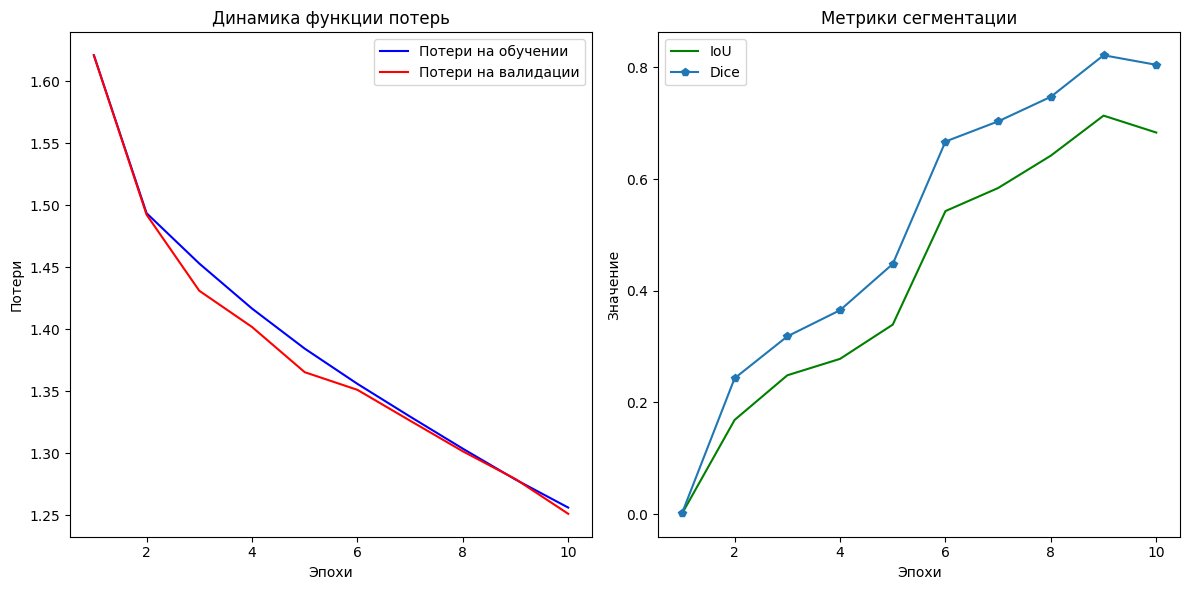

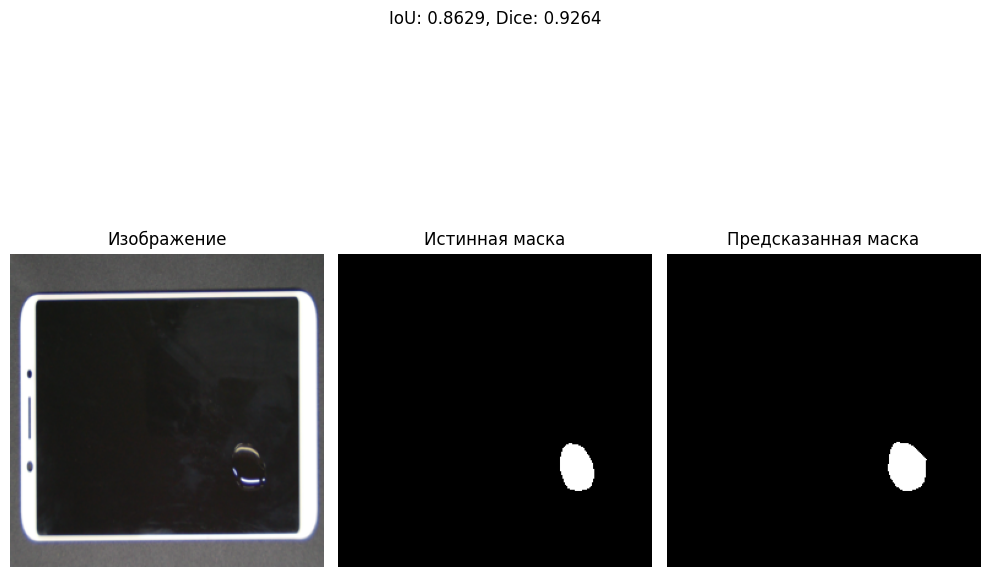

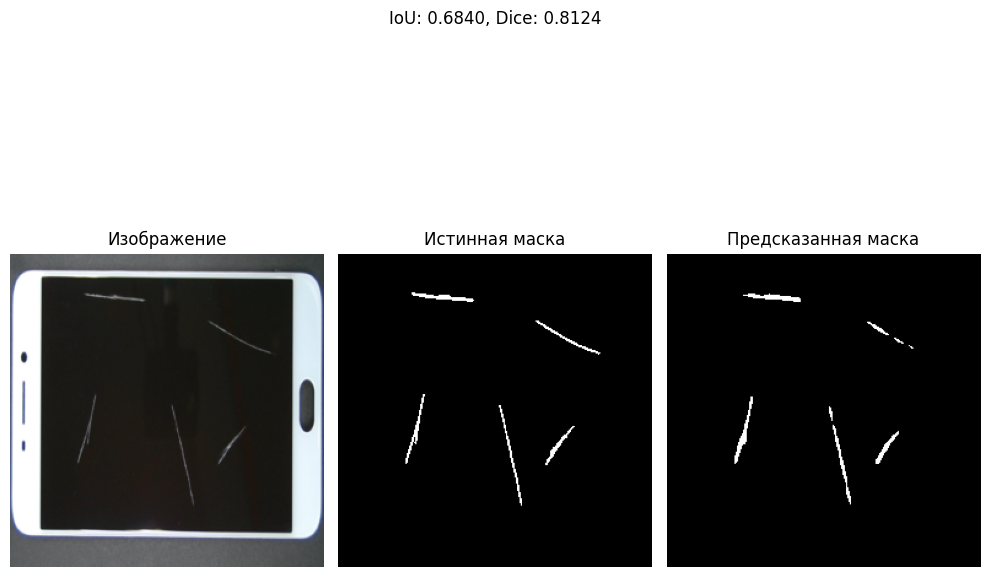

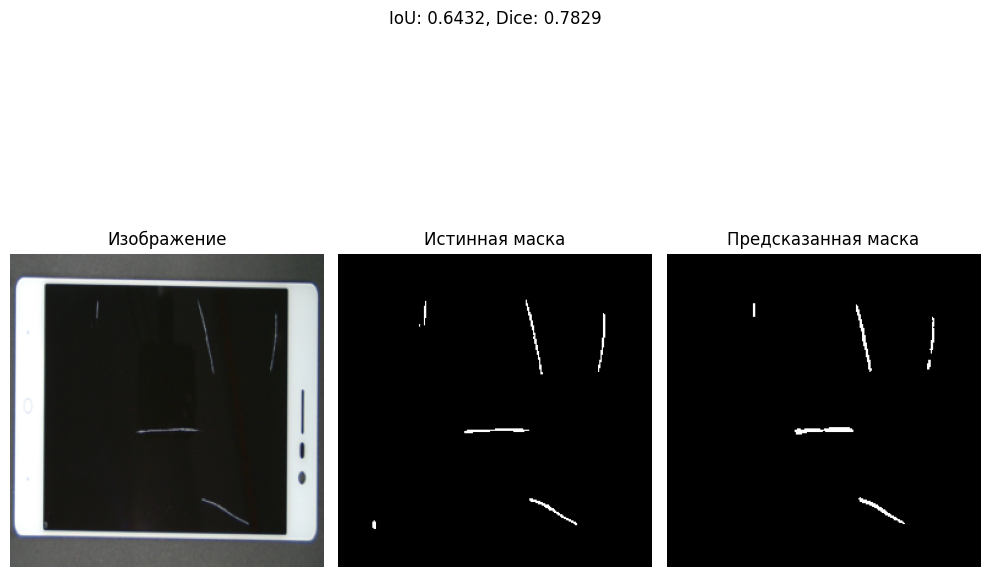

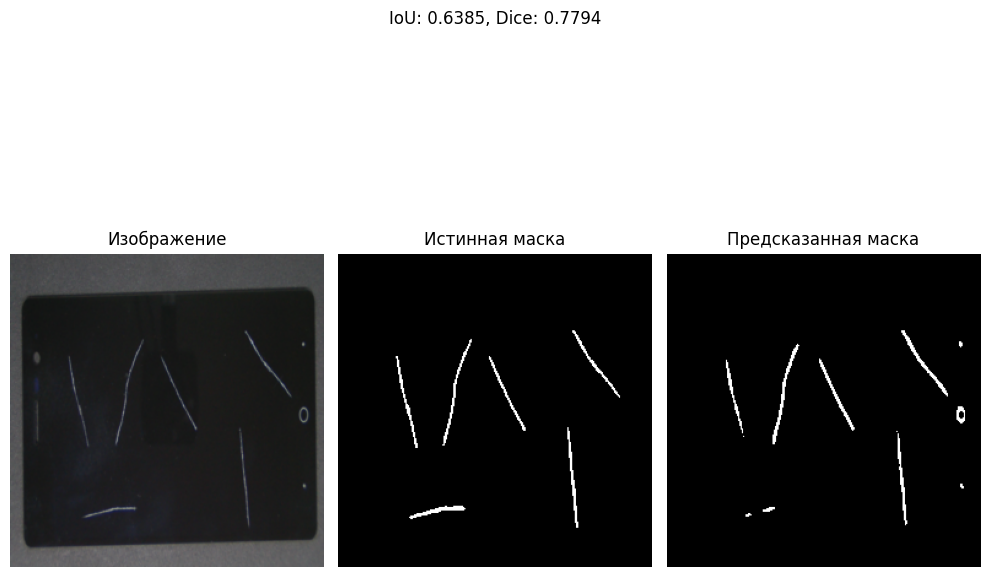

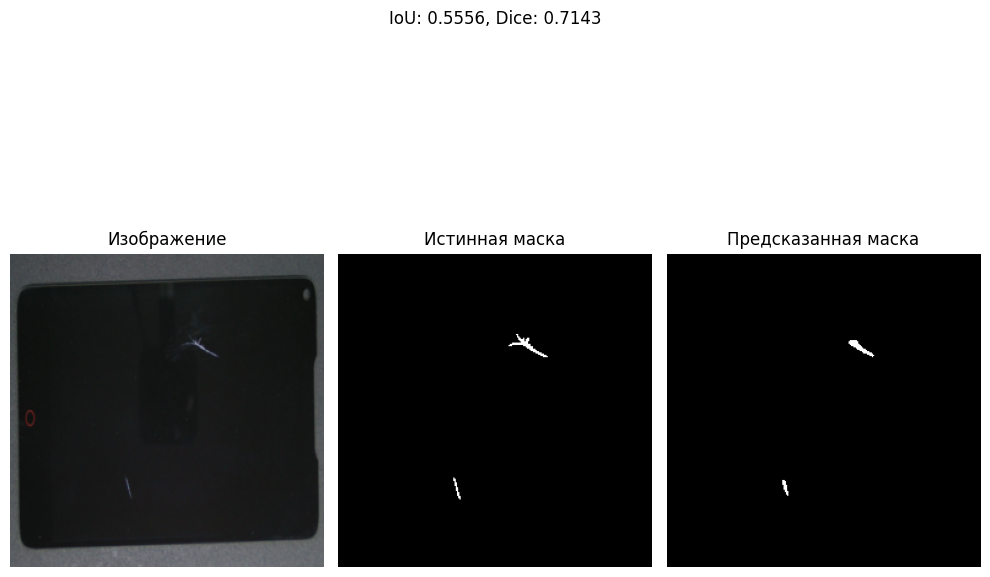

Финальные метрики:
IoU: 0.6833 | Dice: 0.8046
Точность пикселей: 0.9958
Precision: 0.7374 | Recall: 0.9098 | F1: 0.8046


In [ ]:
classes = ['фон', 'дефект']
simple_unet, simple_unet_history, simple_unet_metrics = train_segmentation_pipeline(SimpleUnet, num_epochs=10)

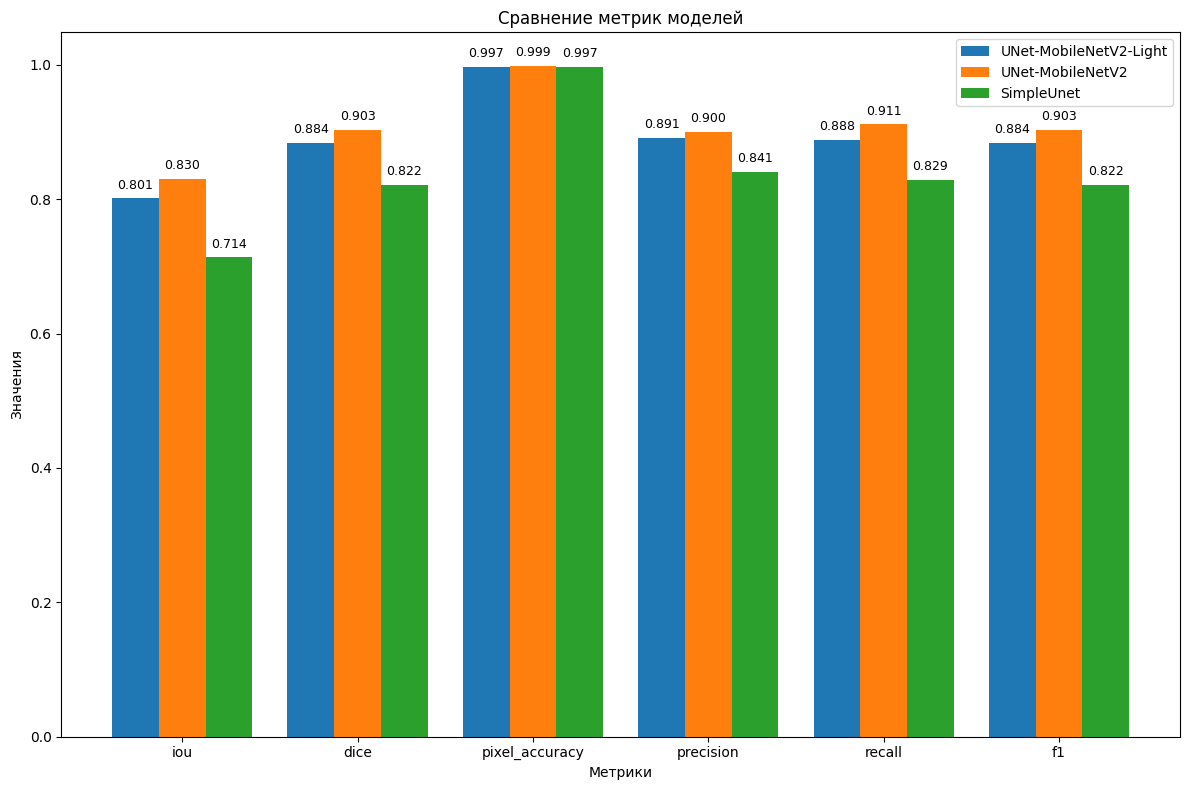

In [ ]:
unet_mobilenetv2_light_metrics = pickle.load(open("unet-mobilenetv2-light_metrics.pkl", "rb"))
unet_mobilenetv2_metrics = pickle.load(open("unet-mobilenetv2_metrics.pkl", "rb"))
simple_unet_metrics = pickle.load(open("simpleunet_metrics.pkl", "rb"))

models_metrics = {
    "UNet-MobileNetV2-Light": unet_mobilenetv2_light_metrics,
    "UNet-MobileNetV2": unet_mobilenetv2_metrics,
    "SimpleUnet": simple_unet_metrics
}

visualize_model_metrics(models_metrics)


В целом собственная реализация Unet примерна похожа на предобученные варианты, но все равно хуже

## С улучшениями

In [ ]:
ImprovedUnet = CustomUNet(n_channels=3, n_classes=1, bilinear=True)
ImprovedUnet.name = "ImprovedUnet"

Начало обучения ...


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.5554
Валидация - Потери: 1.5155, IoU: 0.0234, Dice: 0.0441
Новый лучший IoU: 0.0234


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.3784
Валидация - Потери: 1.3651, IoU: 0.0027, Dice: 0.0050


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.2981
Валидация - Потери: 1.3190, IoU: 0.4148, Dice: 0.5581
Новый лучший IoU: 0.4148


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Потери: 1.2443
Валидация - Потери: 1.2900, IoU: 0.2698, Dice: 0.3979


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Потери: 1.2003
Валидация - Потери: 1.2247, IoU: 0.4592, Dice: 0.5867
Новый лучший IoU: 0.4592


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.1666
Валидация - Потери: 1.1738, IoU: 0.5020, Dice: 0.6326
Новый лучший IoU: 0.5020


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.1332
Валидация - Потери: 1.1171, IoU: 0.7264, Dice: 0.8308
Новый лучший IoU: 0.7264


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.1076
Валидация - Потери: 1.1120, IoU: 0.7480, Dice: 0.8494
Новый лучший IoU: 0.7480


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0870
Валидация - Потери: 1.0839, IoU: 0.6434, Dice: 0.7748


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0720
Валидация - Потери: 1.0738, IoU: 0.7373, Dice: 0.8411


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Потери: 1.0583
Валидация - Потери: 1.0517, IoU: 0.7714, Dice: 0.8640
Новый лучший IoU: 0.7714


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Потери: 1.0490
Валидация - Потери: 1.0434, IoU: 0.7406, Dice: 0.8447


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.0384
Валидация - Потери: 1.0315, IoU: 0.8182, Dice: 0.8959
Новый лучший IoU: 0.8182


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Потери: 1.0308
Валидация - Потери: 1.0237, IoU: 0.8244, Dice: 0.8994
Новый лучший IoU: 0.8244


Валидация: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]it]


Потери: 1.0237
Валидация - Потери: 1.0256, IoU: 0.8295, Dice: 0.9023
Новый лучший IoU: 0.8295
Сохранение модели и метрик ImprovedUnet...
Визуализация результатов ImprovedUnet...


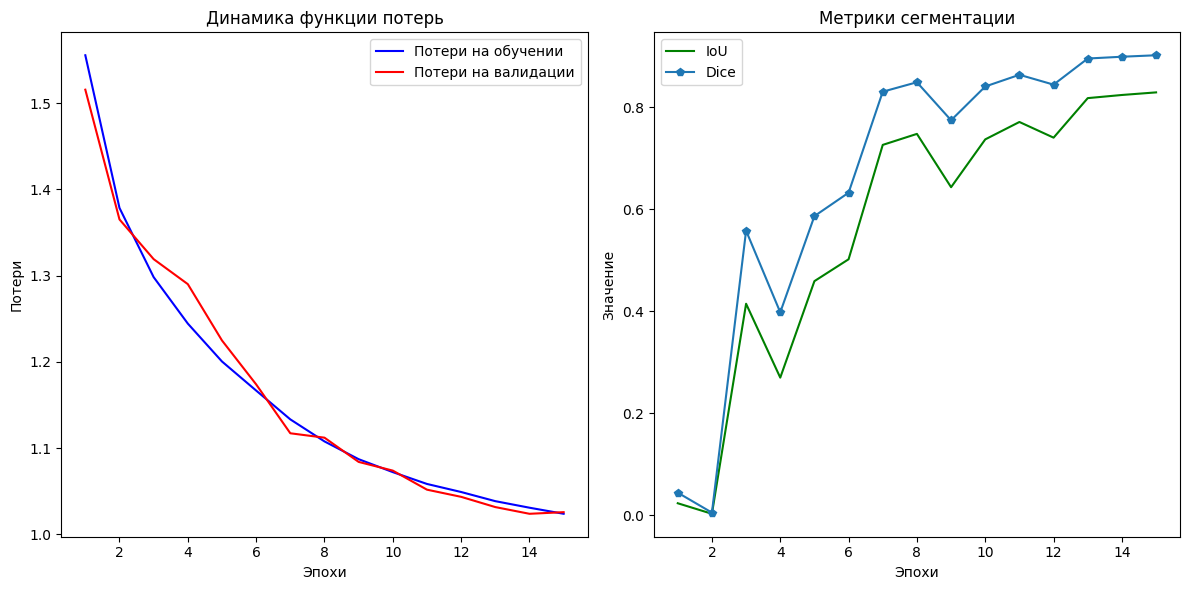

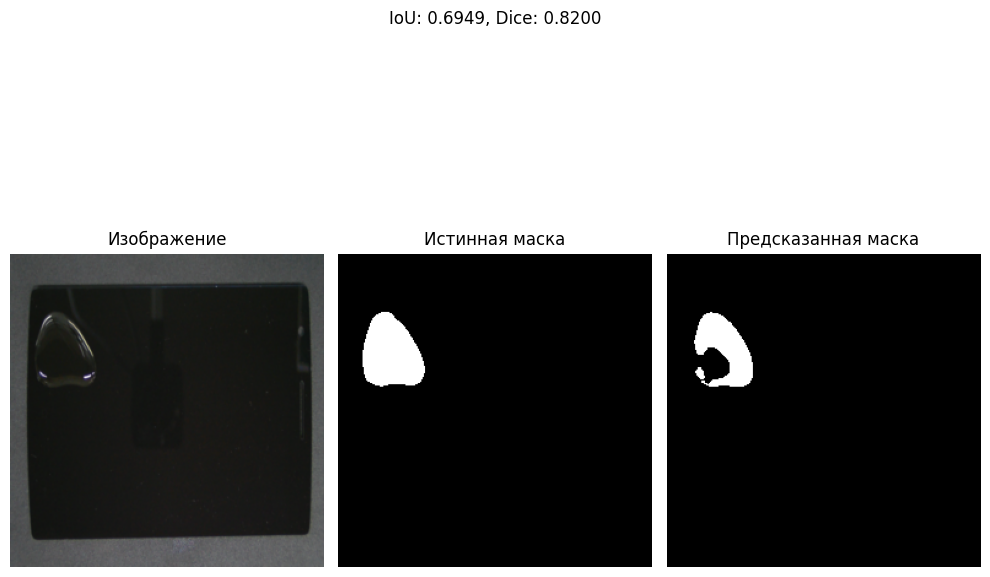

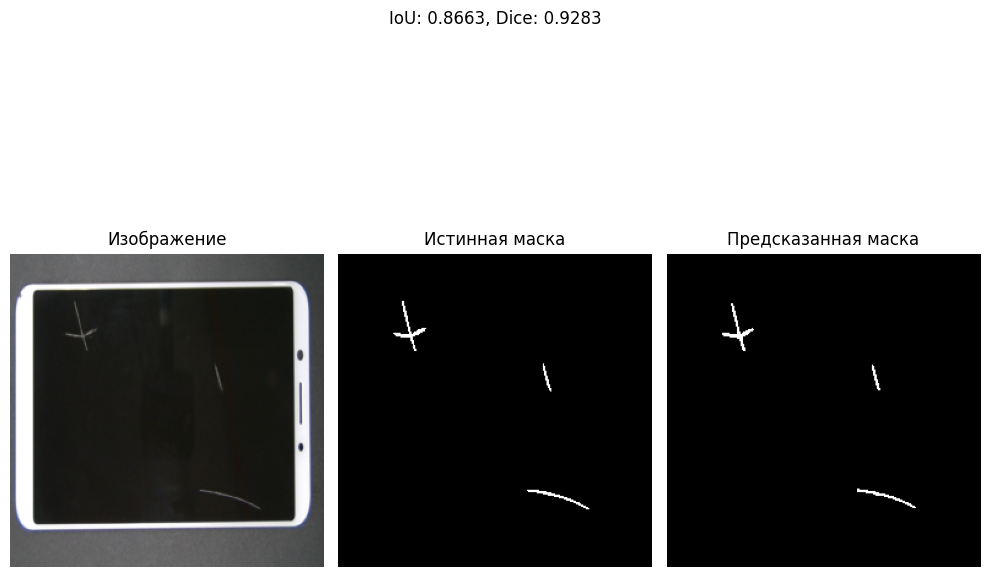

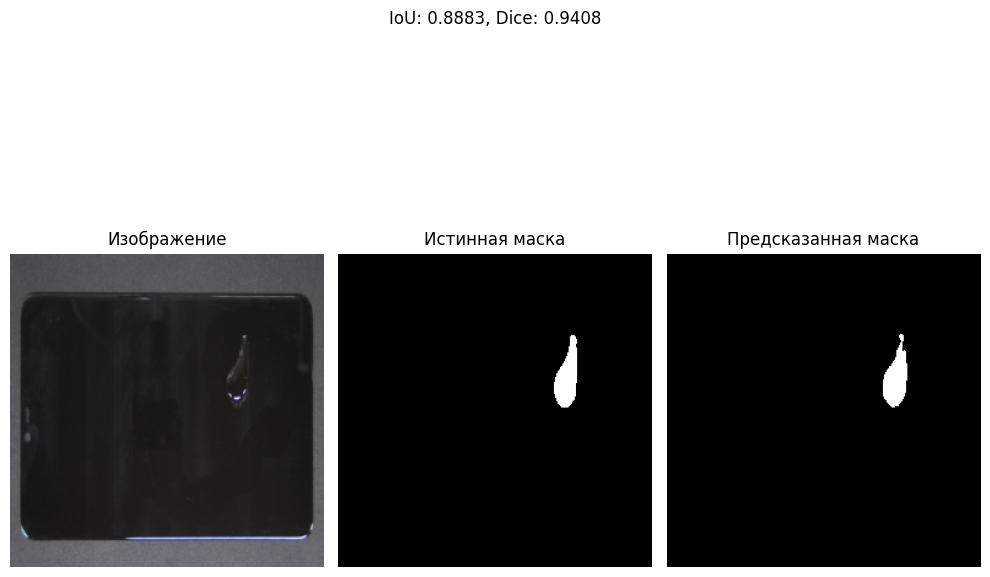

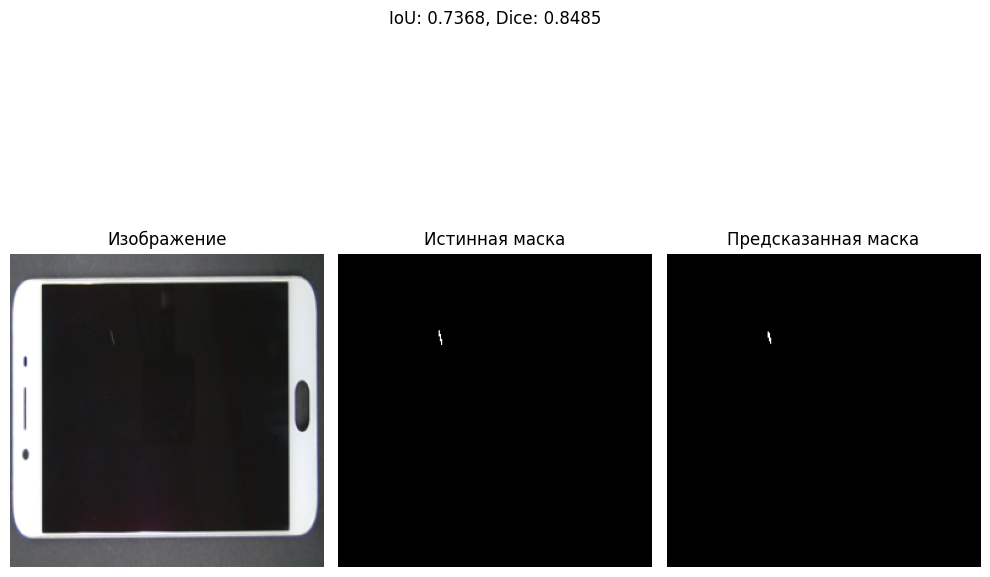

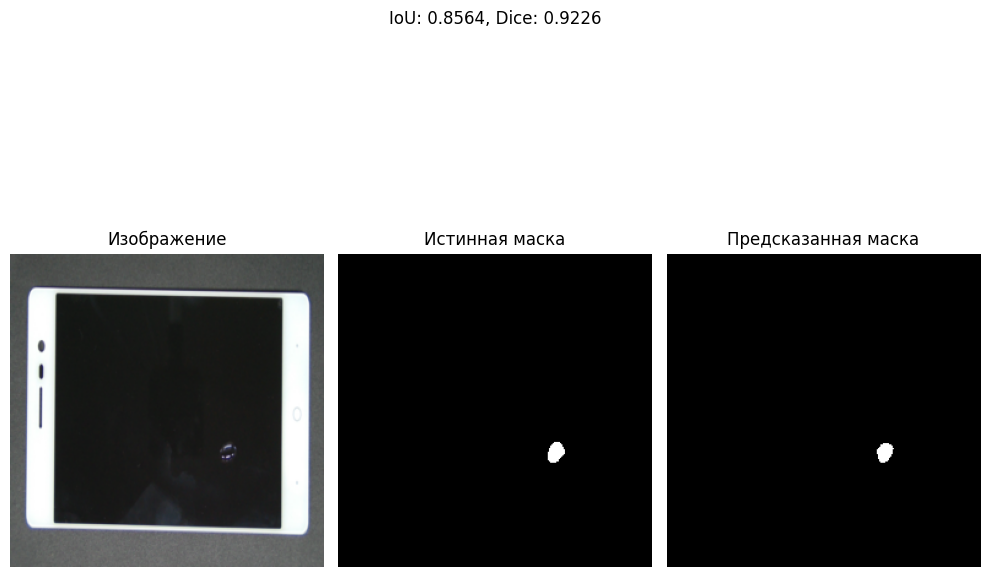

Финальные метрики:
IoU: 0.8295 | Dice: 0.9023
Точность пикселей: 0.9983
Precision: 0.9058 | Recall: 0.9081 | F1: 0.9023


In [ ]:
classes = ['фон', 'дефект']
simple_unet, simple_unet_history, simple_unet_metrics = train_segmentation_pipeline(
    ImprovedUnet,
    train_loader=train_loader_improved,
    test_loader=test_loader_improved,
    lr=0.0005,
    num_epochs=15,  # Увеличиваем количество эпох
    save_model=True,
    visualize_samples=5
)

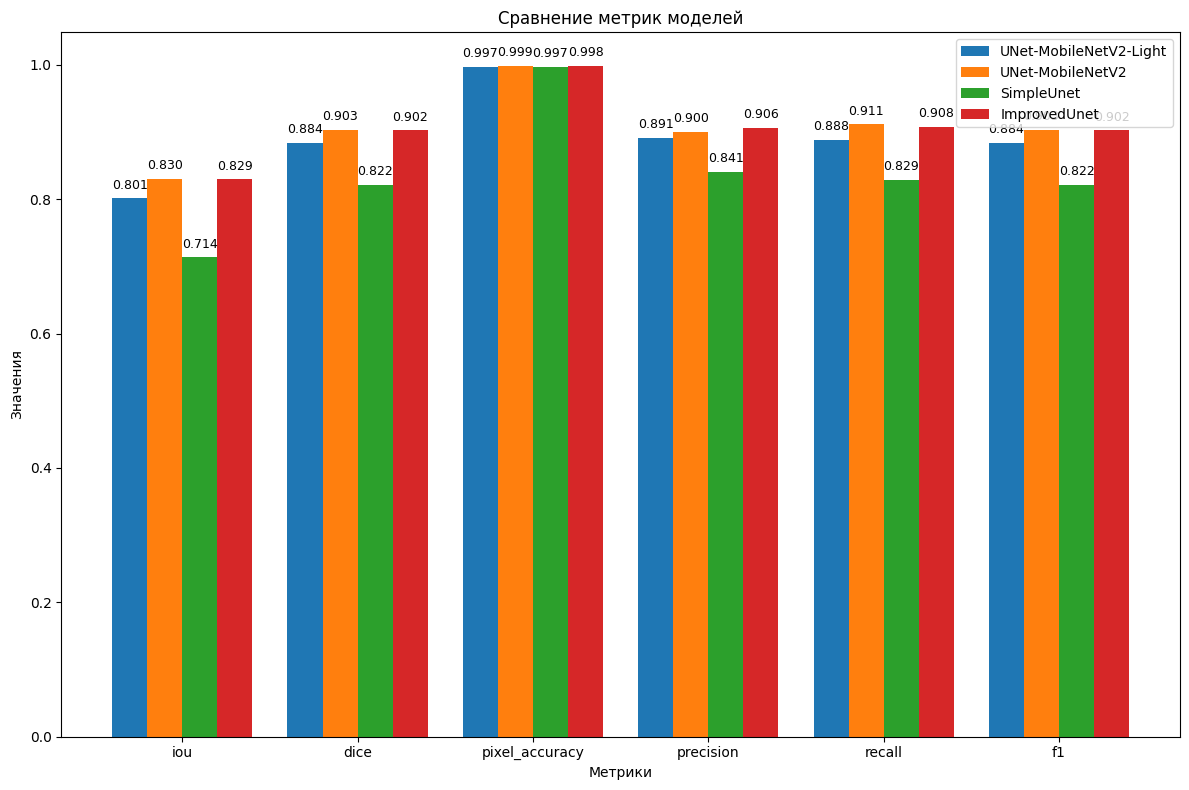

In [ ]:
unet_mobilenetv2_light_metrics = pickle.load(open("unet-mobilenetv2-light_metrics.pkl", "rb"))
unet_mobilenetv2_metrics = pickle.load(open("unet-mobilenetv2_metrics.pkl", "rb"))
simple_unet_metrics = pickle.load(open("simpleunet_metrics.pkl", "rb"))
improved_unet_metrics = pickle.load(open("improvedunet_metrics.pkl", "rb"))

models_metrics = {
    "UNet-MobileNetV2-Light": unet_mobilenetv2_light_metrics,
    "UNet-MobileNetV2": unet_mobilenetv2_metrics,
    "SimpleUnet": simple_unet_metrics,
    "ImprovedUnet": improved_unet_metrics
}

visualize_model_metrics(models_metrics)


Как вы видим более долгое обучение и определенные аугментации данных и подбор гиперпараметров позволил моей реализации Unet приблизиться к результатам предобученных моделей Unet.

FPN_resnet18_metrics = pickle.load(open("fpn_resnet18_metrics.pkl", "rb"))
FPN_efficientnet_b5_metrics = pickle.load(open("fpn-efficientnet-b5_metrics.pkl", "rb"))

models_metrics = {
    "FPN-ResNet18": FPN_resnet18_metrics,
    "FPN-EfficientNet-B5": FPN_efficientnet_b5_metrics
}

visualize_model_metrics(models_metrics)
